# «Модель прогнозирования стоимости жилья для агентства недвижимости»
#### 1 Этап. Предобработка данных

## Описание данных:
* 'status' — статус продажи;
* 'private pool' и 'PrivatePool' — наличие собственного бассейна;
* 'propertyType' — тип объекта недвижимости;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
* 'fireplace' — наличие камина;
* 'city' — город;
* 'schools' — сведения о школах в районе;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'beds' — количество спален;
* 'state' — штат;
* 'stories' — количество этажей;
* 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
* target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

In [1]:
# Загрузка необходимых библиотек
import numpy as np
import pandas as pd
import re
from geopy.geocoders import Nominatim
from fake_useragent import UserAgent
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from geopy.exc import GeocoderServiceError

# Первичный осмотр данных
Посмотрим на выгруженные данные.

In [2]:
df = pd.read_csv('data/data.csv')
display(df.head())
df.info()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Подчистим дубликаты

In [3]:
# сохраняем количество строк до удаления дубликатов
rows_before = df.shape[0]
#удалим дубликаты
df = df.drop_duplicates(ignore_index=True)
# сохраняем количество строк после удаления дубликатов
rows_after = df.shape[0]
# считаем количество удаленных дубликатов
duplicates_removed = rows_before - rows_after
print(f'Удалено {duplicates_removed} дубликатов')

Удалено 50 дубликатов


## Посмотрим на пропуски

In [4]:
missing_data = df.isnull().sum()

# Выводим столбцы, которые содержат пропуски и их количество (в %)
for column_name, missing_count in missing_data.items():
    if missing_count > 0:
        percentage = (missing_count / len(df)) * 100
        print(f'{column_name}: {missing_count} пропусков ({percentage:.2f}% от общего числа данных в столбце)')

status: 39917 пропусков (10.58% от общего числа данных в столбце)
private pool: 372954 пропусков (98.89% от общего числа данных в столбце)
propertyType: 34733 пропусков (9.21% от общего числа данных в столбце)
street: 2 пропусков (0.00% от общего числа данных в столбце)
baths: 106308 пропусков (28.19% от общего числа данных в столбце)
fireplace: 274024 пропусков (72.66% от общего числа данных в столбце)
city: 34 пропусков (0.01% от общего числа данных в столбце)
sqft: 40550 пропусков (10.75% от общего числа данных в столбце)
beds: 91254 пропусков (24.20% от общего числа данных в столбце)
stories: 150674 пропусков (39.95% от общего числа данных в столбце)
mls-id: 352193 пропусков (93.39% от общего числа данных в столбце)
PrivatePool: 336825 пропусков (89.31% от общего числа данных в столбце)
MlsId: 66869 пропусков (17.73% от общего числа данных в столбце)
target: 2480 пропусков (0.66% от общего числа данных в столбце)


In [5]:
# посмотрим что содержится в private pool и PrivatePool
print(df['private pool'].unique())
print(df['PrivatePool'].unique())

[nan 'Yes']
[nan 'yes' 'Yes']


>Так как в 'private pool' и 'PrivatePool' содержится дублирующая информация то объеденим их, так же отметим, поскольку у нас всего 3 значения то вероятнее всего пропуск свидетельствует об отсутствии бассейна закодируем его булевыми переменными, а так же удалим 'mls-id' и 'MlsId' поскольку это признаки существуют для идентификации объекта в общих базах риэлторов для наших задач он не требуется

In [6]:
# Объединяем столбцы
df['pool_encoded'] = df['private pool'].combine_first(df['PrivatePool'])
# Удаляем столбец PrivatePool
df = df.drop(['PrivatePool', 'private pool', 'MlsId', 'mls-id'], axis=1)
# Заменить NaN на False
df['pool_encoded'] = df['pool_encoded'].fillna(False)
# Заменить 'yes' и 'Yes' на True
df['pool_encoded'] = df['pool_encoded'].replace(['yes', 'Yes'], True)
# Выводим результат
print("Уникальные значения 'pool_encoded':", df['pool_encoded'].unique())
display(df.head())


Уникальные значения 'pool_encoded': [False  True]


C:\Users\ilya\AppData\Local\Temp\ipykernel_31796\2430388273.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pool_encoded'] = df['pool_encoded'].replace(['yes', 'Yes'], True)


,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool_encoded
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",False
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",False
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",True
3,for sale,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",False
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",False


In [7]:
# сохраняем количество строк до удаления дубликатов
rows_before = df.shape[0]
#удалим дубликаты
df = df.drop_duplicates(ignore_index=True)
# сохраняем количество строк после удаления дубликатов
rows_after = df.shape[0]
# считаем количество удаленных дубликатов
duplicates_removed = rows_before - rows_after
print(f'Удалено {duplicates_removed} дубликатов')

Удалено 91 дубликатов


### Обработаем признак status

In [8]:
missing_values_count = df.status.isna().sum()
total_count = len(df)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {df.status.nunique()}\n"
      f"Уникальные значения: {list(df.status.unique()[:10])}")

Количество пропущенных значений: 39916
Процент пропущенных значений: 10.59%
Количество уникальных значений: 159
Уникальные значения: ['Active', 'for sale', nan, 'New construction', 'New', 'For sale', 'Pending', 'P', 'Active/Contingent', 'Pre-foreclosure / auction']


#### Разделим статусы на категории а пропуски заменим на other и запишем их

In [9]:
categories = {
    "For Sale": ["for sale", "For sale", "New construction", "New"],
    "Active": [
        "Active", "A Active", "Active/Contingent", "Active Under Contract", "Active Option", "Auction - Active",
        "Active With Contingencies", "Active Option Contract", "Active Contingency", "Active Backup",
        "Active Contingent", "Active - Auction", "Active With Offer", "Active - Contingent", "Active with Contract",
        "Temporary Active", "Re Activated", "Reactivated"
    ],
    "Pending": [
        "P", "Pending", "pending", "P Pending Sale", "Pending Ab", "Pending Continue To Show",
        "Pending Inspection", "Pending Offer Approval", "Pending In", "Pending W/Insp Finance", "Pending Fe",
        "Pending W/Backup Wanted", "Pending Backups Wanted", "Pending With Contingencies", "Lease/Purchase Pending",
        "Pending Bring Backup", "Pending - Taking Backups", "Pending - Continue to Show",
        "Pending Taking Backups", "Offer Pending Signature", "Pending (Do Not Show)", "Pending W/ Cont.",
        "Pending W/Escape Clause", "Pending - Backup Offer Requested", "Pending Sale"
    ],
    "Contingent": [
        "Contingent", "Contingent Finance And Inspection", "Contingent Show",
        "Contingent Take Backup", "Contingent - Sale of Home", "Contingent Finance and Inspection",
        "C Continue Show", "Contingent   Show", "Contingent   Release", "Contingent   No Show",
        "CT Insp - Inspection Contingency", "Contingent   Foreclosure", "Conting Accpt Backups",
        "Contingent - Financing", "Contingency 48 Hr (+/ )", "Contingency Contract", "Contingent Escape"
    ],
    "Foreclosure": [
        "Pre-foreclosure", "Pre-foreclosure / auction", " / auction", "Foreclosed", "foreclosure", "Foreclosure"
    ],
    "Under Contract": [
        "Under Contract", "Under Contract   Showing", "Under Contract Backups", "Under Contract Show",
        "Under Contract - Show", "Under Contract - No Show", "Under contract", "U Under Contract",
        "Due Diligence Period", "Contract Contingent On Buyer Sale", "Contract P", "Ct", "Uc Continue To Show",
        "Under Contract Taking Back Up Offers", "Under Contract W/ Bckp", "Contract"
    ],
    "For Rent": ["for rent", "Apartment for rent", "Condo for rent"],
    "Auction": ["Auction"],
    "Recently Sold": ["recently sold"],
    "Price Change": ["Price Change"],
    "Back on Market": ["Back on Market", "Back On Market"],
    "Closed": ["Closed"],
    "Listing Extended": ["Listing Extended"],
    "Coming Soon": [
        "Coming soon: Nov 21.", "Coming soon: Dec 4.", "Coming soon: Nov 23.", "Coming soon: Nov 29.",
        "Coming soon: Dec 2.", "Coming soon: Dec 10.", "Coming soon: Dec 24.", "Coming soon: Nov 14.",
        "Coming soon: Nov 22.", "Coming soon: Oct 21.", "Coming soon: Dec 14.", "Coming soon: Oct 24.",
        "Coming soon: Dec 18.", "Coming soon: Dec 16.", "Coming soon: Dec 3.", "Coming soon: Dec 25.",
        "Coming soon: Nov 11.", "Coming soon: Nov 28.", "Coming soon: Nov 17.", "Coming soon: Dec 6.",
        "Coming soon: Nov 27.", "Coming soon: Nov 26.", "Coming soon: Dec 7.", "Coming soon: Dec 27.",
        "Coming soon: Dec 11.", "Coming soon: Dec 5.", "Coming soon: Nov 13.", "Coming soon: Nov 19.",
        "Coming soon: Nov 8.", "Coming soon: Oct 29.", "Coming soon: Dec 15.", "Coming soon: Oct 30.",
        "Coming soon: Dec 9.", "Coming soon: Dec 20.", "Coming soon: Dec 13.", "Coming soon: Dec 23.",
        "Coming soon: Nov 30.", "Coming soon: Dec 1.", "Coming soon: Nov 5.", "Coming soon: Nov 12.",
        "Coming soon: Nov 25.", "Coming soon: Nov 9."
    ],
}

def categorize_status(status_value):
    for category, values in categories.items():
        if status_value in values:
            return category
    return "Other"

# заменим значения на категории
df['status'] = df['status'].apply(categorize_status)



In [10]:
# выполним проверку
missing_values_count = df.status.isna().sum()
total_count = len(df)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {df.status.nunique()}\n"
      f"Уникальные значения: {list(df.status.unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 15
Уникальные значения: ['Active', 'For Sale', 'Other', 'Pending', 'Foreclosure', 'Under Contract', 'For Rent', 'Auction', 'Contingent', 'Price Change']


In [11]:
# сохраняем количество строк до удаления дубликатов
rows_before = df.shape[0]
#удалим дубликаты
df = df.drop_duplicates(ignore_index=True)
# сохраняем количество строк после удаления дубликатов
rows_after = df.shape[0]
# считаем количество удаленных дубликатов
duplicates_removed = rows_before - rows_after
print(f'Удалено {duplicates_removed} дубликатов')

Удалено 0 дубликатов


#### Посмотрим на признак propertyType

In [12]:
# выполним проверку
missing_values_count = df.propertyType.isna().sum()
total_count = len(df)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {df.propertyType.nunique()}\n"
      f"Уникальные значения: {list(df.propertyType.unique()[:10])}")

Количество пропущенных значений: 34725
Процент пропущенных значений: 9.21%
Количество уникальных значений: 1280
Уникальные значения: ['Single Family Home', 'single-family home', 'lot/land', 'townhouse', 'Florida', nan, 'Single Family', 'coop', 'English', '2 Story']


In [13]:
# переведем все в строчные
df.propertyType = df.propertyType.str.lower()
# выполним проверку
missing_values_count = df.propertyType.isna().sum()
total_count = len(df)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {df.propertyType.nunique()}\n"
      f"Уникальные значения: {list(df.propertyType.unique()[:10])}")

Количество пропущенных значений: 34725
Процент пропущенных значений: 9.21%
Количество уникальных значений: 1272
Уникальные значения: ['single family home', 'single-family home', 'lot/land', 'townhouse', 'florida', nan, 'single family', 'coop', 'english', '2 story']


Как видно из структуры тип записан в 1 значении отделённым запятой

In [14]:
# Приведем разное написание к одному виду а так же заменим yes и unknown на Other
df.propertyType = df.propertyType \
.str.replace('single-family home','single family') \
.str.replace('single family home','single family') \
.str.replace('yes','Other') \
.str.replace('unknown','Other')
# Создадим признак Type и запишем в него объединенные по 1 слову данные 
df['Type'] = df['propertyType'].str.split(',').str[0]

In [15]:
# выполним проверку
missing_values_count = df.Type.isna().sum()
total_count = len(df)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {df.Type.nunique()}\n"
      f"Уникальные значения: {list(df.Type.unique()[:10])}")

Количество пропущенных значений: 34725
Процент пропущенных значений: 9.21%
Количество уникальных значений: 256
Уникальные значения: ['single family', 'lot/land', 'townhouse', 'florida', nan, 'coop', 'english', '2 story', 'multi-family', 'penthouse']


In [16]:
synonyms_mapping = {
    'single_family_home': [
        'single family', '1 story', '2 story', 'detached', '1 story/ranch', '1 story traditional', 'single detached', 'singlefamilyresidence', 'single wide', 'single-wide mobile with land',
        'two story', 'one story', 'one level unit', 'rancher', '1 1/2 story', 'single wide mh', 'one story traditional'],
    'multi_family_home': [
        'multi-family', 'multi-family home', 'duplex', 'triplex', 'fourplex', 'multi_level', 'multi family', '2 unit condo', '2-story'],
    'condo': [
        'condo', 'coop', 'cooperative', 'condo/townhome/row home/co-op', 'condo/townhome', 'condominium', 'condo/unit', 'apartment/condo/townhouse', 'co-op', '2 story condo', 'high rise'],
    'townhouse': [
        'townhouse', 'townhome style', 'townhouse-interior', 'townhouse-end unit'],
    'apartment': [
        'apartment', 'condominium (single level)', 'high-rise', 'mid-rise', 'low-rise (1-3 stories)', 'Flats', 'studio'],
    'land': [
        'lot/land', 'land'],
    'mobile_home': [
        'mobile/manufactured', 'mobile / manufactured', 'manufactured house', 'mfd/mobile home', 'mobile home', 'manufactured home', 'manufactured double-wide', 'manufactured single-wide', 'mobile home 1 story', 'mobile manu - double wide'],
    'miscellaneous': [
        'miscellaneous'],
    'ranch': [
        'ranch', 'one story'],
    'modern': [
        'contemporary', 'contemporary/modern', "modern", 'mid-century modern', 'modern farmhouse', 'modernist'],
    'historical': [
        'historical', 'designated historical home', 'historical/conservation district', 'historic/older', 'historic vintage', 'historic'],
    'other': [
        'Other', 'english', 'urban contemporary', 'other style', 'florida', 'farms/ranches', 'carriage house', 'country english', 'straight thru', 'less than 4 floors', 'bungalow', 'custom', 'arts & crafts', 'tudor', 'new build 2019', 'split foyer', 'cottage', 'cottage/camp', 'garden home', 'farm/ranch', 'farm/ranch house', 'farm house', 'hi ranch', 'attached duplex', 'farmhouse', 'houseboat', 'ground floor', 'victorian', '3 story', '3+ stories', 'santa barbara/tuscan', 'old style', 'modular/prefab', 'post and beam', 'manuf/mobile', 'multiple occupancy', 'attached', 'hawaiian plantation', 'forest garden home', '1 1/2 story with basement', 'split-entry', 'texas hill country', 'lake house', '1 story with basement', 'hi-rise', 'coastal beach home', 'historical', 'key west/coastal', 'loft/balcony', 'english manor', 'mid-rise (4-7 stories)', 'mid-level', 'new englander', 'residential (<1 acre)', 'ranch','residential (1+ acre)', 'split', 'split level', 'split (4 level)', 'split (5+ level)', 'urban', 'patio', 'patio home', 'penthouse', 'manor', 'victorian/federal', 'coastal', 'coastal contemporary', 'coastal ii', 'coastal modern', 'coastal two story', 'mountain contemporary', 'key west', 'high ranch', 'end unit']
}


def replace_synonyms(value):
    for key, synonym_values in synonyms_mapping.items():
        if value in synonym_values:
            return key
    return "other"

# Замена синонимов
df['Type'] = df['Type'].apply(replace_synonyms)



In [17]:
# выполним проверку
missing_values_count = df.Type.isna().sum()
total_count = len(df)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {df.Type.nunique()}\n"
      f"Уникальные значения: {list(df.Type.unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 12
Уникальные значения: ['single_family_home', 'land', 'townhouse', 'other', 'condo', 'multi_family_home', 'mobile_home', 'apartment', 'modern', 'miscellaneous']


In [18]:
# теперь propertyType можно удалить
df.drop('propertyType', axis=1, inplace=True)

Обработаем Признак street

In [19]:
# выполним проверку
missing_values_count = df.street.isna().sum()
total_count = len(df)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {df.street.nunique()}")

Количество пропущенных значений: 2
Процент пропущенных значений: 0.00%
Количество уникальных значений: 337076


In [20]:
# удаляем строки, где есть пропуски в столбце street
df = df.dropna(subset=['street'])

#### C помощью библиотеки geopy получим кординаты расположения

In [ ]:
#user_agent = UserAgent().random
#geolocator = Nominatim(user_agent=user_agent, timeout=10)
#
#def get_coordinates(address, retry_count=3):
#    if retry_count <= 0:
#       return None
#
#    try:
#        location = geolocator.geocode(address)
#        if location:
#            return (location.latitude, location.longitude)
#        else:
#            return None
#    except (GeocoderTimedOut, GeocoderUnavailable, GeocoderServiceError):
#        return get_coordinates(address, retry_count - 1)
#
#df['coordinates'] = df['street'].apply(get_coordinates)

Поскольку данный способ очень продолжительный по времени пришлось от него отказаться. Оставим пока этот признак так как не понятно как его можно использовать, но информация из него может пригодиться в дальнейшем

Обработаем признак baths

In [21]:
# выполним проверку
missing_values_count = df.baths.isna().sum()
total_count = len(df)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {df.baths.nunique()}\n"
      f"Уникальные значения: {list(df.baths.unique()[:10])}")

Количество пропущенных значений: 106260
Процент пропущенных значений: 28.18%
Количество уникальных значений: 229
Уникальные значения: ['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3', 'Bathrooms: 2', '1,750', '4 Baths']


In [22]:
# Удаляем все буквы, пробелы и двоеточия
df.baths = df.baths.str.replace('[a-zA-Z:]','', regex=True)
# Удаляем все пробелы
df.baths = df.baths.str.replace(' ','', regex=True)

In [23]:
# выполним проверку
missing_values_count = df.baths.isna().sum()
total_count = len(df)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {df.baths.nunique()}\n"
      f"Уникальные значения: {list(df.baths.unique()[:10])}")

Количество пропущенных значений: 106260
Процент пропущенных значений: 28.18%
Количество уникальных значений: 148
Уникальные значения: ['3.5', '3', '2', '8', nan, '1,750', '4', '5', '1,000', '7']


In [24]:
# сделаем копию что бы не перезапускать весь код в случае ошибок
df1=df.copy()

Пропуски заполним нулями так как большинство пропущенных значений соответствуют земле где нет здания

In [25]:
# поправим кривые значения
df1['baths'] = df1['baths'].str.replace('[a-zA-Z+:]','', regex=True)
df1['baths'].replace(['nan','', '~', '..', '--', '—','0.0','0.00','0/0'], 0, inplace=True)
df1['baths'].replace(['1-2','1/1-0/1-0/1-0', '1/1/1/1','1-0/1-0/1', ], 1, inplace=True)
df1['baths'].replace(['2-1/2-1/1-1/1-1','3-1/2-2',], 2, inplace=True)
df1['baths'].replace(['116/116/116'], 116, inplace=True)
df1['baths'].replace(['7,500'], 7.5, inplace=True)
df1['baths'].replace(['5,000'], 5, inplace=True)
df1['baths'].replace(['3,500'], 3.5, inplace=True)
df1['baths'].replace(['2,750'], 2.75, inplace=True)
df1['baths'].replace(['2,250'], 2.25, inplace=True)
df1['baths'].replace(['1,250'], 1.25, inplace=True)
df1['baths'].replace(['1,500'], 1.5, inplace=True)
df1['baths'].replace(['4,000'], 4, inplace=True)
df1['baths'].replace(['2,000'], 2, inplace=True)
df1['baths'].replace(['3,000'], 3, inplace=True)
df1['baths'].replace(['2,500'], 2.5, inplace=True)
df1['baths'].replace(['1,000'], 1, inplace=True)
df1['baths'].replace(['1,750'], 1.75, inplace=True)
df1['baths'] = df1['baths'].fillna(0)

C:\Users\ilya\AppData\Local\Temp\ipykernel_31796\2363063889.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['baths'].replace(['nan','', '~', '..', '--', '—','0.0','0.00','0/0'], 0, inplace=True)


In [26]:
# переведем в числовой признак и округлим до целого числа
df1['baths'] = df1['baths'].astype(float).round()

In [27]:
# Отбираем строки по заданным условиям при помощи логических операций (& - "и", | - "или", ~ - "не")
selected_rows = df1[(df1['baths'] == 0) & ((df1['Type'] == 'other') | (df1['Type'] == 'land') | (df1['Type'] == 'ranch'))]

# Выводим полученные строки
display(selected_rows.head())
# Находим процент выбранных строк от общего числа строк в исходном датафрейме
percent_selected = len(selected_rows) / len(df1) * 100
# Выводим полученные строки и процент выбранных строк
print(f"Процент выбранных строк от общего числа строк: {percent_selected:.2f}%")

,status,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool_encoded,Type
4,For Sale,1524 Kiscoe St,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",False,land
6,Active,552 Casanova Ct,0.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...","1,507",34759,NaN,FL,One,"181,500",False,other
7,Active,6094 Mingle Dr,0.0,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,TN,NaN,"68,000",False,other
11,Active,4222 False Cypress Ln,0.0,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Houston,"[{'rating': ['6', '3', '6', '1', '5'], 'data':...","3,130",77068,NaN,TX,2,"260,000",False,other
40,Active,1104 Rotonda Cir,0.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,ROTONDA WEST,"[{'rating': ['6', '6', '7'], 'data': {'Distanc...",NaN,33947,NaN,FL,NaN,"54,000",False,other


Процент выбранных строк от общего числа строк: 19.36%


In [28]:
selected_rows = df1[(df1['baths'] == 0) & ~(df1['Type'].isin(['other', 'land', 'ranch']))]
display(selected_rows.head())
# Находим уникальные значения признака status в выбранных строках
unique_statuses = selected_rows['Type'].unique()
# Выводим полученные строки и процент выбранных строк
print(f"Уникальные значения признака Type в выбранных строках: {unique_statuses}")
percent_selected = len(selected_rows) / len(df1) * 100
print(f"Процент выбранных строк от общего числа строк: {percent_selected:.2f}%")


,status,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool_encoded,Type
5,For Sale,1624 S Newkirk St,0.0,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,"$209,000",False,townhouse
15,For Sale,930 52nd St,0.0,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,NY,NaN,"1,650,000",False,single_family_home
17,Active,24 W 126th St,0.0,"{'atAGlanceFacts': [{'factValue': '1899', 'fac...",NaN,New York,"[{'rating': ['2', '5', '1', '2'], 'data': {'Di...","3,325",10027,NaN,NY,NaN,"2,650,000",False,townhouse
35,For Sale,423 N Church St #13-A,0.0,"{'atAGlanceFacts': [{'factValue': '1981', 'fac...",NaN,Charlotte,"[{'rating': ['7/10', '4/10', '8/10'], 'data': ...",900 sqft,28202,2 Beds,NC,NaN,"$260,000",False,condo
71,For Sale,8451 24th Ave SW,0.0,"{'atAGlanceFacts': [{'factValue': '1918', 'fac...",NaN,Seattle,"[{'rating': ['6/10', '3/10', '4/10'], 'data': ...",770 sqft,98106,2 Beds,WA,1.0,"$475,000",False,single_family_home


Уникальные значения признака Type в выбранных строках: ['townhouse' 'single_family_home' 'condo' 'apartment' 'modern'
 'miscellaneous' 'multi_family_home' 'mobile_home' 'historical']
Процент выбранных строк от общего числа строк: 10.25%


In [29]:
# выполним проверку
missing_values_count = df1.baths.isna().sum()
total_count = len(df1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {df1.baths.nunique()}\n"
      f"Уникальные значения: {list(df1.baths.unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 49
Уникальные значения: [4.0, 3.0, 2.0, 8.0, 0.0, 5.0, 1.0, 7.0, 6.0, 9.0]


>**Итог: 29.61% заменили значением 0, из них 19.36% это ранчо чемля и иной тип, что в полне может быть правдой и 10.25% 'таунхаус', 'дом на одну семью', 'кондоминиум', 'квартира', 'современный', 'разное', 'многосемейный_дом', 'мобильный_дом' и 'исторический' из них минимум половина действительно может не иметь ванной комнаты, а значит такой результат можно считать оптимальным.**

#### Обработаем признак 'homeFacts'

In [30]:
# выполним проверку
missing_values_count = df1.homeFacts.isna().sum()
total_count = len(df1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df1.homeFacts.nunique()}\n"
f"Уникальные значения: {list(df1.homeFacts.unique()[:1])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 321008
Уникальные значения: ["{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"]


С помощью регулярных выражений извлечём из этого признака значения для Value и Label

In [31]:
label = df1.homeFacts.str.findall(r"\bfactLabel': ([\s\S]+?)[}\b]")
label[100]

["'Year built'",
 "'Remodeled year'",
 "'Heating'",
 "'Cooling'",
 "'Parking'",
 "'lotsize'",
 "'Price/sqft'"]

In [32]:
Value = df.homeFacts.str.findall(r"\bfactValue': ([\s\S]+?), 'factLabel\b")
Value[:10]

0    ['2019', '', 'Central A/C, Heat Pump', '', '',...
1    ['2019', '', '', '', '', '5828 sqft', '$159/sq...
2    ['1961', '1967', 'Forced Air', 'Central', 'Att...
3    ['2006', '2006', 'Forced Air', 'Central', 'Det...
4            ['', '', '', '', '', '10,019 sqft', None]
5    ['1920', '', 'Forced Air', 'Central', '', '680...
6    ['2006', '2006', 'Electric, Heat Pump', 'Centr...
7    ['1976', '', '', '', '', '8,750 Sq. Ft.', '$57...
8    ['1970', '', 'Forced Air', 'Central', '', '124...
9    ['2019', None, 'Gas', 'Central', 'Attached Gar...
Name: homeFacts, dtype: object

In [33]:
# создадим список названий признаков, удалив лишние кавычки
list_label = ','.join(label[0]).replace("'","").split(',')
list_label

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [34]:
# Создадим эти признаки в нашем фрейме и заполним значениями
for i, val in enumerate(list_label):
    df1[val]=Value.apply(lambda x: x[i])

In [35]:
# Теперь признак homeFacts можно удалить
df1 = df1.drop('homeFacts', axis=1)

#### Далее обработаем новые признаки

посмотрим на Year built

In [36]:
#удалим лишние кавычки
df1['Year built'] = df1['Year built'].str.replace("'",'', regex=True)
#Выведем уникальные значения
df1['Year built'].sort_values().unique()[:10]

array(['', '1', '1019', '1057', '1060', '1208', '1700', '1703', '1735',
       '1740'], dtype=object)

* 1019', '1057', '1060 скорее всего опечатка должно выглядеть вод так 1919','1957', '1960
* '', '1','1208', '2025', '559990649990', 'No Data' заменим на -1

In [37]:
# Заменим ковычки на no date
df1['Year built'] = df1['Year built'].str.replace('^\s*$','no date', regex=True)
# Заменим некорректные значения на no date
mask= df1['Year built'].isin(['1','1208','559990649990','2025','No Data','None'])
df1.loc[mask,'Year built'] = 'no date'
# Поправим опечатки
df1.loc[df1['Year built']=='1019','Year built'] = '1919'
df1.loc[df1['Year built']=='1057','Year built'] = '1957'
df1.loc[df1['Year built']=='1060','Year built'] = '1960'
# Выведим результат обработки
df1['Year built'].sort_values().unique()[:10]

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ilya\AppData\Local\Temp\ipykernel_31796\1548276437.py:2: SyntaxWarning: invalid escape sequence '\s'
  df1['Year built'] = df1['Year built'].str.replace('^\s*$','no date', regex=True)


array(['1700', '1703', '1735', '1740', '1750', '1780', '1788', '1790',
       '1794', '1795'], dtype=object)

In [38]:
# Отбираем строки по заданным условиям при помощи логических операций (& - "и", | - "или", ~ - "не")
selected_rows = df1[(df1['Year built'] == 'no date') & ((df1['Type'] == 'other') | (df1['Type'] == 'land') | (df1['Type'] == 'ranch'))]

# Выводим полученные строки
display(selected_rows.head())
# Находим процент выбранных строк от общего числа строк в исходном датафрейме
percent_selected = len(selected_rows) / len(df1) * 100
# Выводим полученные строки и процент выбранных строк
print(f"Выбранных строк: {len(selected_rows)}")
print(f"Процент выбранных строк от общего числа строк: {percent_selected:.2f}%")

,status,street,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,target,pool_encoded,Type,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
4,For Sale,1524 Kiscoe St,0.0,NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,...,"$5,000",False,land,no date,'','','','',"'10,019 sqft'",None
26,Active,5755 SW 123 Ave,1.0,NaN,Miami,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,33183,Baths,FL,...,"799,000",False,other,no date,'','','','','—',None
40,Active,1104 Rotonda Cir,0.0,NaN,ROTONDA WEST,"[{'rating': ['6', '6', '7'], 'data': {'Distanc...",NaN,33947,NaN,FL,...,"54,000",False,other,no date,'','','','','—',None
41,For Sale,9418 Camino Santa Fe #19,0.0,NaN,San Diego,"[{'rating': ['9/10', '9/10', '9/10'], 'data': ...",NaN,92127,NaN,CA,...,"$1,100,000",False,land,no date,'','','','','9.25 acres',None
42,Active,MLS #: STRI1057289,0.0,NaN,New York,"[{'rating': ['NR', 'NR', '9', '8', '8', '2', '...",NaN,10006,NaN,NY,...,"850,000",False,other,no date,'2003','','','','—',None


Выбранных строк: 44783
Процент выбранных строк от общего числа строк: 11.88%


In [39]:
selected_rows = df1[(df1['Year built'] == 'no date') & ~(df1['Type'].isin(['other', 'land', 'ranch']))]
display(selected_rows.head())
# Находим уникальные значения признака status в выбранных строках
unique_statuses = selected_rows['Type'].unique()
# Выводим полученные строки и процент выбранных строк
print(f"Уникальные значения признака Type в выбранных строках: {unique_statuses}")
percent_selected = len(selected_rows) / len(df1) * 100
print(f"Выбранных строк: {len(selected_rows)}")
print(f"Процент выбранных строк от общего числа строк: {percent_selected:.2f}%")

,status,street,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,target,pool_encoded,Type,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
27,For Sale,2104 Lou Ellen Ln #B,3.0,NaN,Houston,"[{'rating': ['6/10', '9/10', '3/10'], 'data': ...","2,575 sqft",77018,3 Beds,TX,...,"$499,900",False,single_family_home,no date,'','','','','3828 sqft','$194/sqft'
57,For Sale,1134 Longitude Dr,2.0,NaN,Durham,"[{'rating': ['3/10', '4/10', '3/10'], 'data': ...","1,681 sqft",27713,3 Beds,NC,...,"$259,658",False,townhouse,no date,'','','','','','$154/sqft'
59,For Sale,9027 Indigo Breeze Ct,2.0,NaN,Temple Terrace,"[{'rating': ['2/10', '3/10', '2/10'], 'data': ...","1,504 sqft",33637,3 Beds,FL,...,"$244,990",False,single_family_home,no date,'','','','','','$163/sqft'
83,For Sale,3894 Chapman Bluff Dr,3.0,NaN,Spring,"[{'rating': ['9/10', '9/10', '8/10'], 'data': ...","2,265 sqft",77386,4 Beds,TX,...,"$299,999",False,single_family_home,no date,'','','','','','$132/sqft'
91,Active,15125 Mille Fiore Blvd.,2.0,NaN,Port Charlotte,"[{'rating': ['5', '4', '6', '1', 'NR', 'NR', '...","1,702",33953,3,FL,...,"$235,900",False,single_family_home,no date,'','','','',None,'$139'


Уникальные значения признака Type в выбранных строках: ['single_family_home' 'townhouse' 'condo' 'miscellaneous'
 'multi_family_home' 'apartment' 'mobile_home' 'modern']
Выбранных строк: 18700
Процент выбранных строк от общего числа строк: 4.96%


In [40]:
# выполним проверку
missing_values_count = df1['Year built'].isna().sum()
total_count = len(df1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df1['Year built'].nunique()}\n"
f"Уникальные значения: {list(df1['Year built'].sort_values().unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 222
Уникальные значения: ['1700', '1703', '1735', '1740', '1750', '1780', '1788', '1790', '1794', '1795']


In [41]:
# посмотрим на колличество no date в %
print(f"Процент no date: {round(df1[df1['Year built']=='no date'].shape[0]/df.shape[0]*100, 2)}%")
print(f"Количество no date: {df1.loc[df1['Year built']=='no date', 'Year built'].count()}")

Процент no date: 16.84%
Количество no date: 63483


>Большая часть значений 'no date' соответствуют типу земля, ранчо и другое 11.88%, что в полне похоже на реальность, к остальным же типам относится 4.96% 'no date', это много что бы удалить строки, но и заполнить рандомно год постройки мы не можем, так что оставим в таком виде.

#### Посмотрим на признак Remodeled year

In [42]:
#удалим лишние кавычки
df1['Remodeled year'] = df1['Remodeled year'].str.replace("'",'', regex=True)
#Выведем уникальные значения
df1['Remodeled year'].sort_values().unique()[:10]

array(['', '0', '1111', '1738', '1800', '1845', '1846', '1853', '1862',
       '1869'], dtype=object)

In [43]:
# Заменим некорректные значения на None
mask= df1['Remodeled year'].isin(['', '0', '1111'])
df1.loc[mask,'Remodeled year'] = 'None'
#Выведем уникальные значения
display(df1['Remodeled year'].sort_values().unique()[:10])

array(['1738', '1800', '1845', '1846', '1853', '1862', '1869', '1870',
       '1874', '1876'], dtype=object)

In [44]:
# выполним проверку
missing_values_count = df1['Remodeled year'].isna().sum()
total_count = len(df1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df1['Remodeled year'].nunique()}\n"
f"Уникальные значения: {list(df1['Remodeled year'].sort_values().unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 152
Уникальные значения: ['1738', '1800', '1845', '1846', '1853', '1862', '1869', '1870', '1874', '1876']


In [45]:
# посмотрим на колличество None в %
print(f"Процент None: {round(df1[df1['Remodeled year']=='None'].shape[0]/df.shape[0]*100, 2)}%")
print(f"Количество None: {df1.loc[df1['Remodeled year']=='None', 'Remodeled year'].count()}")

Процент None: 60.0%
Количество None: 226240


Пропусков слишком много однозначно признак на удаление

In [46]:
# удалим признак 'Remodeled year'
df1 = df1.drop('Remodeled year', axis=1)

Посмотрим на признак 'Heating'

In [47]:
display(df1['Heating'].str.lower().value_counts().head(10))

Heating
'forced air'          134307
''                    105670
'other'                29622
'electric'             10216
'gas'                   9295
'heat pump'             8851
'no data'               8610
'central air'           7814
'central electric'      7112
'central'               6247
Name: count, dtype: int64

Признак у казывает нам на наличие отопления, возможно его нет у участвков и мобильных домов, проверим это

In [48]:
# Рассчитываем процент для признаков land и mobile_home
land_percentage = (df1['Type'].value_counts().loc['land'] / len(df1)) * 100
mobile_home_percentage = (df1['Type'].value_counts().loc['mobile_home'] / len(df1)) * 100

#Выводим результаты
print("Процент значений 'land' и 'mobile_home': {:.2f} %".format(land_percentage + mobile_home_percentage))

Процент значений 'land' и 'mobile_home': 9.27 %


>**Таким образом - признак содержит информацию о типах отопления и имеет значительное колличество пропусков ''-105434, 'no data' - 8415, 'none' - 3485 суммарно - 117334. Значений что составляет 31% вычтем % мобильных домов и земли, получим примерно 21% пропусков, так же видно, что у части домов где нет признака отопление есть камин или стоимость такого дома значительно ниже чем похожий но с отоплением. Из это принимаем решение закодировать этот признак булевыми переменными ''-105434, 'no data' - 8415, 'none' - 3485 будет 'False', а остальные 'True'.**

In [49]:
# удалим лишние ковычки
df1['Heating'] = df1['Heating'].str.replace("'",'', regex=True)
df1['Heating_encoded'] = df1['Heating'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none'] else False)

In [50]:
# выполним проверку
missing_values_count = df1['Heating_encoded'].isna().sum()
total_count = len(df1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df1['Heating_encoded'].nunique()}\n"
f"Уникальные значения: {list(df1['Heating_encoded'].sort_values().unique())}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 2
Уникальные значения: [False, True]


In [51]:
# удалим признак 'Heating'
df1= df1.drop('Heating', axis=1)

Посмотрим на признак Cooling- охлождение скорее всего кондиционер

In [52]:
df1['Cooling'].str.lower().value_counts().head(10)

Cooling
'central'             158742
''                    120306
'central air'          14384
'no data'              10615
'has cooling'           9730
'none'                  7390
'central electric'      6154
'wall'                  4017
'central gas'           3573
none                    3533
Name: count, dtype: int64

Аналогичная ситуация получается и с кондиционерами - более 50% пропусков, скорее всего кондиционер просто отсутствует

In [53]:
# удалим лишние ковычки
df1['Cooling'] = df1['Cooling'].str.replace("'",'', regex=True)
df1['Cooling_encoded'] = df1['Cooling'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none'] else False)

In [54]:
# удалим признак 'Cooling'
df1= df1.drop('Cooling', axis=1)

Посмотрим на Parking 

In [55]:
df1['Parking'].str.lower().value_counts().head(10)

Parking
''                   171755
'attached garage'     70748
'2 spaces'            28061
'1 space'             14252
'no data'             13332
'detached garage'     13200
'carport'              7743
'off street'           5279
'3 spaces'             4724
none                   3533
Name: count, dtype: int64

Признак Parking так же имеет очень много пропусков - 50%. И с большой вероятностью пропуски это отсутствие парковки.

In [56]:
# удалим лишние ковычки
df1['Parking'] = df1['Parking'].str.replace("'",'', regex=True)
df1['Parking_encoded'] = df1['Parking'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none','0'] else False)

In [57]:
# удалим признак 'Parking'
df1 = df1.drop('Parking', axis=1)

Посмотрим на признак lotsize

In [58]:
df1['lotsize'].str.lower().value_counts().head(10)

lotsize
''               33055
none             28346
'—'              25247
'no data'         5329
'-- sqft lot'     3819
'0.26 acres'      3140
'0.25 acres'      2722
'0.28 acres'      2614
'0.27 acres'      2473
'0.29 acres'      2351
Name: count, dtype: int64

Пропусков более 48%. Этот признак лучше удалить, так как во-первых это площадь участка на котором расположен дом, а во-вторых этот признак числовой, заполнять его нет сысла так как мы ухудшим предсказание.

In [59]:
# удалим признак 'lotsize'
df1 = df1.drop('lotsize', axis=1)

Признак Price/sqft напрямую зависит от целевого признака. Поэтому оставлять его нельзя, иначе будет утечка данных.

In [60]:
# удалим признак 'Price/sqft'
df1= df1.drop('Price/sqft', axis=1)

Посмотрим на признак fireplace

In [61]:
df1['fireplace'].str.lower().value_counts().head(10)

fireplace
yes               71209
1                 14543
2                  2432
not applicable     1993
fireplace           847
3                   564
living room         433
location            399
wood burning        311
gas/gas logs        300
Name: count, dtype: int64

Будем считать что пропуски в признаке наличия камина так же указывают на его отсутствие так же закодируем его булевым значением

In [62]:
df1['fireplace_encoded'] = df1['fireplace'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none', '0', 'not applicable', 'no'] and not pd.isna(x) else False)

In [63]:
# удалим столбец
df1.drop('fireplace', axis=1, inplace=True)

Посмотрим на признак city

In [64]:
# Приведем названия к единому виду
df1['city'] = df1['city'].str.title()
# выполним проверку
missing_values_count = df1['city'].isna().sum()
total_count = len(df1)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df1['city'].nunique()}\n"
f"Уникальные значения: {list(df1['city'].sort_values().unique()[:10])}")

Количество пропущенных значений: 32
Процент пропущенных значений: 0.01%
Количество уникальных значений: 1909
Уникальные значения: [' ', '--', 'Abilene', 'Abingdon', 'Accokeek', 'Adams', 'Addison', 'Adel', 'Adelphi', 'Advance']


In [65]:
df1['city'].str.lower().value_counts().sort_index().head(10)

city
             25
--            9
abilene     134
abingdon    116
accokeek      3
adams         5
addison      25
adel         13
adelphi       6
advance       3
Name: count, dtype: int64

>В итоге на удаление - 66 строк

In [66]:
#сделаем копию
df2=df1.copy()

In [67]:
# Удалим приставку Сity в названии городов
df2['city'] = df2['city'].str.replace(' City', '') 
#сохраняем исходное количество строк
initial_row_count = df2.shape[0]

#удаляем строки, содержащие ' ', '--' или NaN в столбце 'city'
df2 = df2[~df2['city'].isin([' ', '--', np.nan])]

#подсчитываем количество удаленных строк
removed_row_count = initial_row_count - df2.shape[0]

print(f"Количество удаленных строк: {removed_row_count}")

Количество удаленных строк: 66


In [68]:
# выполним проверку
missing_values_count = df2['city'].isna().sum()
total_count = len(df2)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df2['city'].nunique()}\n"
f"Уникальные значения: {list(df2['city'].sort_values().unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 1897
Уникальные значения: ['Abilene', 'Abingdon', 'Accokeek', 'Adams', 'Addison', 'Adel', 'Adelphi', 'Advance', 'Akron', 'Alamo Heights']


Признак schools

In [69]:
# посморим на структуру
df2.schools[5]

"[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]"

>Данный признак содержит сведения о рейтинге школы, растоянии до школы, оценки и наименование. Оценки и наименования не дают нам никакой полезной информации, а вот среднее растояние до школы и средний рейтинг был бы крайне полезен.

In [70]:
# Рассчитаем средний рейтинг
def process_rating(rating):
    rating = rating[0].replace('/10', '')
    extracted_numbers = [float(num) for num in rating if num.isdigit()]
    average_rating = np.average(extracted_numbers) if extracted_numbers else -1
    return round(average_rating, 1)

s_rating = (
    df2.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
    .apply(lambda x: process_rating(x))
)

# Создадим признак school_rating _mean в нашем наборе данных. Пропуски заполним -1 
df2['school_rating _mean'] = s_rating

In [71]:
#Расчитаем минимальную дистанцию
s_distance = df2.schools.str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b") 
# Извлечение расстояний до школ из каждой строки
s_distance = s_distance.apply(lambda x: x[0]) 
# Получение первого найденного значения списков, полученных в результате предыдущего шага
s_distance = s_distance.str.replace('[a-zA-Z]','', regex=True) 
# Удаление всех символов алфавита из расстояний
s_distance = s_distance.str.findall(r'\b([0-9]+.[0-9]+)') 
# Извлечение чисел виде Точноечисло, включая десятичные значения
s_distance = s_distance.apply(lambda x: [float(i) for i in x]) 
# Конвертирование каждого числового значения списка в тип float
school_dist_min = s_distance.apply(lambda x: -1 if len(x)==0 else min(x)) 
# Нахождение минимального значения в каждом списке s_distance, и возвращение -1, если длина списка равна 0

#Создадим признак school_dist_min в нашем наборе данных. Пропуски заполним -1
df2['school_dist_min'] = school_dist_min

In [72]:
# теперь признак schools можно удалить
df2.drop('schools', axis=1, inplace=True)

Посмотрим признак sqft- площадь

In [73]:
# выполним проверку
missing_values_count = df2['sqft'].isna().sum()
total_count = len(df2)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df2['sqft'].nunique()}\n"
f"Уникальные значения: {list(df2['sqft'].sort_values().unique()[:10])}")

Количество пропущенных значений: 40516
Процент пропущенных значений: 10.75%
Количество уникальных значений: 25396
Уникальные значения: ['--', '-- sqft', '0', '1', '1 sqft', '1,000', '1,000 sqft', '1,001', '1,001 sqft', '1,002']


In [74]:
df3=df2.copy()

In [75]:
s_sqft = df3.sqft[df3.sqft.notna()]
s_sqft = s_sqft.str.findall(r"\d+")
s_sqft = s_sqft.apply(lambda x: ''.join(x))
df3.loc[df3.sqft.notna(), 'sqft']=s_sqft
# Заменю пропуски в признаке sqft на значение "0"
df3.sqft = df3.sqft.fillna(0)
# также есть пустые строки вместо значения. заменим их тоже 0
df3.loc[df3.sqft=='','sqft']=0
df3.sqft = df3.sqft.astype(int)

In [76]:
# выполним проверку
missing_values_count = df3['sqft'].isna().sum()
total_count = len(df3)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df3['sqft'].nunique()}\n"
f"Уникальные значения: {list(df3['sqft'].sort_values().unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 9890
Уникальные значения: [0, 1, 2, 3, 4, 5, 6, 10, 11, 12]


In [77]:
# Отбираем строки по заданным условиям при помощи логических операций (& - "и", | - "или", ~ - "не")
selected_rows = df3[(df3['sqft'] == 0) & ((df3['Type'] == 'other') | (df3['Type'] == 'land') | (df3['Type'] == 'ranch'))]

# Выводим полученные строки
display(selected_rows.head())
# Находим процент выбранных строк от общего числа строк в исходном датафрейме
percent_selected = len(selected_rows) / len(df3) * 100
# Выводим полученные строки и процент выбранных строк
print(f"Выбранных строк: {len(selected_rows)}")
print(f"Процент выбранных строк от общего числа строк: {percent_selected:.2f}%")

,status,street,baths,city,sqft,zipcode,beds,state,stories,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
4,For Sale,1524 Kiscoe St,0.0,Palm Bay,0,32908,NaN,FL,NaN,"$5,000",False,land,no date,False,False,False,False,4.7,3.03
7,Active,6094 Mingle Dr,0.0,Memphis,0,38115,NaN,TN,NaN,"68,000",False,other,1976,False,False,False,False,2.7,0.40
26,Active,5755 SW 123 Ave,1.0,Miami,0,33183,Baths,FL,NaN,"799,000",False,other,no date,False,False,False,False,3.8,0.90
40,Active,1104 Rotonda Cir,0.0,Rotonda West,0,33947,NaN,FL,NaN,"54,000",False,other,no date,False,False,False,False,6.3,3.10
41,For Sale,9418 Camino Santa Fe #19,0.0,San Diego,0,92127,NaN,CA,NaN,"$1,100,000",False,land,no date,False,False,False,False,9.0,0.97


Выбранных строк: 46145
Процент выбранных строк от общего числа строк: 12.24%


In [78]:
selected_rows = df3[(df3['sqft'] == 0) & ~(df3['Type'].isin(['other', 'land', 'ranch']))]
display(selected_rows.head())
# Находим уникальные значения признака status в выбранных строках
unique_statuses = selected_rows['Type'].unique()
# Выводим полученные строки и процент выбранных строк
print(f"Уникальные значения признака Type в выбранных строках: {unique_statuses}")
percent_selected = len(selected_rows) / len(df3) * 100
print(f"Выбранных строк: {len(selected_rows)}")
print(f"Процент выбранных строк от общего числа строк: {percent_selected:.2f}%")

,status,street,baths,city,sqft,zipcode,beds,state,stories,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
15,For Sale,930 52nd St,0.0,Brooklyn,0,11219,NaN,NY,NaN,"1,650,000",False,single_family_home,1905,False,True,False,False,6.3,0.20
56,Active,2014 Eastbourne Dr,2.0,Southern Pines,0,28387,2,NC,1,"$166,500",False,condo,1998,False,False,False,False,5.6,0.90
193,Foreclosure,3058 Shire Dr,0.0,Pottstown,0,19464,4 bd,PA,NaN,"$170,933",False,single_family_home,1974,True,False,False,False,4.7,2.20
221,For Sale,895 Park Ave #6/7A,8.0,New York,0,10075,6 Beds,NY,NaN,"$15,000,000",False,condo,1930,False,False,False,False,4.3,0.19
232,For Sale,545 N Dearborn St #2511,2.0,Chicago,0,60654,2 Beds,IL,2.0,"$525,000",False,condo,2003,True,True,True,False,4.0,0.57


Уникальные значения признака Type в выбранных строках: ['single_family_home' 'condo' 'miscellaneous' 'multi_family_home'
 'townhouse' 'mobile_home' 'modern' 'apartment']
Выбранных строк: 6981
Процент выбранных строк от общего числа строк: 1.85%


Большая часть '0' - это земля, ранчо и другое. К признакам точно определяющих строение относится 1.85% нулей, так что оставим как есть.

Посмотрим на признак zipcode

In [79]:
# выполним проверку
missing_values_count = df3['zipcode'].isna().sum()
total_count = len(df3)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df3['zipcode'].nunique()}\n"
f"Уникальные значения: {list(df3['zipcode'].sort_values().unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 4549
Уникальные значения: ['--', '0', '00000', '02108', '02109', '02110', '02111', '02113', '02114', '02115']


In [80]:
#Выведем строки с нерорректными значениями 
df3[(df3['zipcode']=='--') | (df3['zipcode']=='0')| (df3['zipcode']=='00000') ]

,status,street,baths,city,sqft,zipcode,beds,state,stories,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
30258,Active,Gates Canyon Rd,0.0,Vacaville,0,0,NaN,CA,NaN,"$380,000",False,land,no date,False,False,False,False,3.7,6.50
83514,For Sale,Cornejo Ricardo Descalzi,0.0,Quito Ecuador,0,0,NaN,NY,NaN,"470,000",False,other,1995,False,True,False,False,-1.0,-1.00
231230,For Sale,0 N Gopher Canyon Rd,0.0,Bonsall,0,--,449 acres,CA,NaN,"$60,000,000",False,other,no date,False,False,False,False,5.7,2.90
235154,Other,1744 N Dixie Hwy # 1744,3.0,Fort Lauderdale,2043,--,3,FL,NaN,"$425,000",False,townhouse,2010,True,True,True,False,5.0,0.50
305481,For Sale,000 U.S. Hwy 359,0.0,Laredo,243849,0,NaN,TX,NaN,"$1,740,000",False,land,no date,False,False,False,False,4.0,7.45
308135,Active,435 pescador,0.0,Foreign Country,1100,00000,NaN,OS,NaN,"125,000",False,other,1972,False,False,False,False,-1.0,-1.00


Всего 6 строк с некорректрными значениями удалим их

In [81]:
# Отфильтровываем индексы строк, удовлетворяющих условию
indexes_to_drop = df3[(df3['zipcode']=='--') | (df3['zipcode']=='0')| (df3['zipcode']=='00000')].index

# Удаляем строки с отфильтрованными индексами
df3 = df3.drop(indexes_to_drop)

In [82]:
# посмотрим что получилось
df3.zipcode.sort_values().unique()[:10]

array(['02108', '02109', '02110', '02111', '02113', '02114', '02115',
       '02116', '02118', '02119'], dtype=object)

In [83]:
# Поправим не корректные zipcode отбросив 2ю часть
df3.zipcode = df3.zipcode.str.replace("-.+",'', regex=True)
# посмотрим что получилось
df3.zipcode.sort_values().unique()[:10]

array(['02108', '02109', '02110', '02111', '02113', '02114', '02115',
       '02116', '02118', '02119'], dtype=object)

Посмотрим на признак beds - колличество спален

In [84]:
# выполним проверку
missing_values_count = df3['beds'].isna().sum()
total_count = len(df3)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df3['beds'].nunique()}\n"
f"Уникальные значения: {list(df3['beds'].sort_values().unique()[:10])}")

Количество пропущенных значений: 91155
Процент пропущенных значений: 24.18%
Количество уникальных значений: 1181
Уникальные значения: [' ', '# Bedrooms 1st Floor', '-- bd', '-- sqft', '0', '0.0', '0.25 acres', '0.26 acres', '0.27 acres', '0.28 acres']


Можно сказать, что эти данные вообще не пригодны, так как часть строк заполнена текстом, часть колличеством спален, а часть площадью. Удаляем его.

In [85]:
df3 = df3.drop('beds', axis=1)

#### Посмотрим на признак state

In [86]:
print(f"Количество пропущенных значений: {df3.state.isna().sum()}\n"
      f"Количество уникальных значений: {df3.state.nunique()}\n"
      f"Уникальные значения: {list(df3.state.unique()[:10])}")

Количество пропущенных значений: 0
Количество уникальных значений: 37
Уникальные значения: ['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR']


В данном признаке всё хорошо

### Теперь посмотрим на stories этажи

In [87]:
# выполним проверку
missing_values_count = df3['stories'].isna().sum()
total_count = len(df3)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df3['stories'].nunique()}\n"
f"Уникальные значения: {list(df3['stories'].sort_values().unique()[:10])}")

Количество пропущенных значений: 150515
Процент пропущенных значений: 39.93%
Количество уникальных значений: 346
Уникальные значения: [', 1', ', 2', ', 3', '0', '0.0', '1', '1 1/2 Levels', '1 1/2 Story', '1 Level', '1 Level, 1.5 Level']


In [88]:
# посмотрим в каких типах пропуски
df3[df3.stories.isna()].Type.value_counts()

Type
single_family_home    46300
other                 37000
land                  28815
condo                 24355
multi_family_home      5212
townhouse              3937
mobile_home            1499
ranch                  1389
modern                 1129
apartment               824
historical               44
miscellaneous            11
Name: count, dtype: int64

Пропуски встречаются как в типе земли, так и в типах домов в большом колличестве. Заполнять рандомно нет смысла, лучше удалить этот признак.

In [89]:
df3 = df3.drop('stories', axis=1)

### Теперь посмотрим целевой признак target

In [90]:
# выполним проверку
missing_values_count = df3['target'].isna().sum()
total_count = len(df3)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
f"Количество уникальных значений: {df3['target'].nunique()}\n"
f"Уникальные значения: {list(df3['target'].sort_values().unique()[:10])}")

Количество пропущенных значений: 2475
Процент пропущенных значений: 0.66%
Количество уникальных значений: 43936
Уникальные значения: ['$1', '$1,000', '$1,000,000', '$1,000,000+', '$1,000,036', '$1,000,050', '$1,000,100', '$1,000,898', '$1,000/mo', '$1,001,713']


In [91]:
# Удалим строки с пропусками так как мы не можем их заполнить и потом использовать
df3 = df3.dropna(subset=['target'])

В признаке есть значения указывающие что это плата за месяц с приставкой '/мо', а следовательно это аренда посморим на них

In [92]:
df3[df3.target.str.contains('/mo',regex=True)].head()

,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
547,For Rent,4323 N Central Park Ave,4.0,Chicago,3300,60618,IL,"$5,500/mo",False,single_family_home,1913,True,False,True,True,2.3,0.13
609,For Rent,220 Boylston St #1412,2.0,Boston,1673,2116,MA,"$10,500/mo",False,multi_family_home,1985,False,False,False,True,-1.0,-1.00
2075,For Rent,2830 NE 56th Ct,4.0,Fort Lauderdale,2400,33308,FL,"$6,390/mo",True,single_family_home,1965,False,False,False,False,4.0,1.19
3025,For Rent,411 Kline Aly,2.0,Clarksville,1280,37040,TN,"$1,200/mo",False,multi_family_home,2014,True,False,False,False,8.0,0.68
3645,For Rent,240 E Illinois St #2011,2.0,Chicago,1473,60611,IL,"$3,600/mo",True,multi_family_home,2003,False,False,True,False,5.5,0.72


In [93]:
# вычисляем количество строк, удовлетворяющих условию
matching_rows = df3[df3.target.str.contains('/mo',regex=True)]
# вычисляем общее число строк в DataFrame
total_rows = len(df3)
# вычисляем процент строк, удовлетворяющих условию
percent_matching = (len(matching_rows) / total_rows) * 100
print('{}% строк содержат подстроку "/mo" в столбце "target".'.format(round(percent_matching, 2)))

0.11% строк содержат подстроку "/mo" в столбце "target".


>Поскольку у нас стоит задача спрогнозировать именно стоимость недвижимости, а не стоимость аренды, и принимая во внимание, что таких строк у нас всего 0.11% можно сделать вывод, что данные строки лучше удалить, так как они будут давать погрешность.

In [94]:
df3 = df3[~df3['target'].str.contains('/mo', regex=True)]

In [95]:
#Теперь удалим все символы кроме цыфр и переведем в числовой формат
df3.loc[:,'target'] = df3.loc[:,'target'].str.replace('[^0-9]','',regex=True)
df3.target = df3.target.astype(int)

In [96]:
display(df3[df3['target'] == df3['target']. min ()].head())
display(df3[df3['target'] == df3['target']. max ()].head())

,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
15533,Active,1230 Old Dickerson Rd,2.0,Goodlettsville,1596,37072,TN,1,False,single_family_home,1940,True,False,True,False,2.3,0.2
25334,Other,3205 N High School Rd,1.0,Indianapolis,1586,46224,IN,1,False,single_family_home,1957,True,True,True,True,1.5,0.2
84943,Foreclosure,7804 Hamilton Ave,0.0,Cincinnati,2536,45231,OH,1,False,land,1865,False,True,True,True,2.0,0.5
148219,Active,Cummings St,0.0,Huntley,0,60142,IL,1,False,land,no date,False,False,False,False,-1.0,-1.0
205315,Active,Route 47 Hwy,0.0,Huntley,0,60142,IL,1,False,land,no date,False,False,False,False,7.8,0.9


,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
132407,For Sale,875 Nimes Rd,18.0,Los Angeles,0,90077,CA,195000000,True,single_family_home,1935,True,True,True,True,2.7,1.3


>По максимальной цене вопросов нет - это огромная вилла, а вот по минимальным есть вопросы. Видим наличие странных показателей по минимальной стоимости, посморим сколько у нас таких значений за границу возьмем - 1000.

In [97]:
# считаем количество строк
count = len(df3[df3['target'] < 1000])
# считаем процент от общего числа строк
percentage = count / len(df3) * 100
# выводим результаты
print(f"Количество строк: {count}")
print(f"Процент строк: {percentage:.2f}%")

Количество строк: 77
Процент строк: 0.02%


Видим, что таких строк всего 77, целесообразно удалить их

In [98]:
df3 = df3.drop(df3[df3['target'] < 1000].index)

In [99]:
display(df3[df3['target'] == df3['target']. min ()].head())

,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
1357,Foreclosure,3314 Whitney St,2.0,Detroit,2544,48206,MI,1000,False,single_family_home,1914,True,False,True,False,3.2,0.79
1682,Other,18997 Annchester Rd,2.0,Detroit,1572,48219,MI,1000,False,single_family_home,1940,True,True,True,False,1.0,0.70
2282,Foreclosure,13715 Linnhurst St,2.0,Detroit,2048,48205,MI,1000,False,single_family_home,1925,True,False,True,False,2.9,1.08
2644,Foreclosure,14903 Sussex St,2.0,Detroit,1827,48227,MI,1000,False,single_family_home,1928,True,False,True,False,2.9,0.56
2673,Active,0 Simpson Ave,0.0,Memphis,0,38106,TN,1000,False,other,no date,False,False,False,False,2.8,0.60


In [100]:
missing_data = df3.isnull().sum()
missing_columns = missing_data[missing_data > 0]

if missing_columns.empty:
    print('Пропуски отсутствуют')
else:
    for column_name in missing_columns.index:
        missing_count = missing_columns[column_name]
        percentage = (missing_count / len(df3)) * 100
        print(f'{column_name}: {missing_count} пропусков ({percentage:.2f}% от общего числа данных в столбце)')


Пропуски отсутствуют


In [101]:
# Проверим дубликаты 
df3.duplicated().sum() 

303

In [102]:
# Удалим дубликаты
df3 = df3.drop_duplicates(ignore_index=True)

Признак street удалим после очистки от выбросов


Очистим наши данные от строк содержащие большое колличество пропусков 

In [103]:
result = df3[
    (df3['baths'] == 0) & 
    (df3['sqft'] == 0) & 
    (df3['Year built'] == 'no date')
]
display(result.head())

num_of_rows_with_nans = len(result)
total_num_of_rows = len(df3)
percentage_of_rows_with_nans = num_of_rows_with_nans / total_num_of_rows * 100

print(f"Найдено {num_of_rows_with_nans} строк с пропусками из {total_num_of_rows} общего числа строк ({percentage_of_rows_with_nans:.2f}%)")


,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
4,For Sale,1524 Kiscoe St,0.0,Palm Bay,0,32908,FL,5000,False,land,no date,False,False,False,False,4.7,3.03
40,Active,1104 Rotonda Cir,0.0,Rotonda West,0,33947,FL,54000,False,other,no date,False,False,False,False,6.3,3.10
41,For Sale,9418 Camino Santa Fe #19,0.0,San Diego,0,92127,CA,1100000,False,land,no date,False,False,False,False,9.0,0.97
42,Active,MLS #: STRI1057289,0.0,New York,0,10006,NY,850000,False,other,no date,False,False,False,False,7.0,0.10
48,Active,18b Sitton-Mills Pl,0.0,Signal Mountain,0,37377,TN,125000,False,other,no date,False,False,False,False,6.3,3.90


Найдено 41873 строк с пропусками из 373717 общего числа строк (11.20%)


Как мы видим, у нас 11.2% строк не несущие никакой полезной информации для прогноза - удалим эти строки.

In [104]:
# Удаление строк
df3 = df3[
    ~((df3['baths'] == 0) &
      (df3['sqft'] == 0) &
      (df3['Year built'] == 'no date'))
]
display(df3.head())
df3.info()

,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
0,Active,240 Heather Ln,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,12911 E Heroy Ave,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,For Sale,2005 Westridge Rd,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,4311 Livingston Ave,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
5,For Sale,1624 S Newkirk St,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00


<class 'pandas.core.frame.DataFrame'>
Index: 331844 entries, 0 to 373716
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               331844 non-null  object 
 1   street               331844 non-null  object 
 2   baths                331844 non-null  float64
 3   city                 331844 non-null  object 
 4   sqft                 331844 non-null  int32  
 5   zipcode              331844 non-null  object 
 6   state                331844 non-null  object 
 7   target               331844 non-null  int32  
 8   pool_encoded         331844 non-null  bool   
 9   Type                 331844 non-null  object 
 10  Year built           331844 non-null  object 
 11  Heating_encoded      331844 non-null  bool   
 12  Cooling_encoded      331844 non-null  bool   
 13  Parking_encoded      331844 non-null  bool   
 14  fireplace_encoded    331844 non-null  bool   
 15  school_rating _mean  3

In [105]:
# Сохраним наши пред обработанные данные в CSV-файл
df3.to_csv("data/cleaned_data.csv", index=False)

### 2 Этап. Анализ данных

In [170]:
# Загрузка библиотек
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go
import scipy as sp
import scipy.optimize as spo
from scipy import stats
import statsmodels.api as sm
import itertools
from itertools import chain
from scipy.stats import shapiro
from scipy.stats import anderson
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import category_encoders as ce

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [107]:
# функция для визуализации распределения числовых признаков

def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

In [108]:
# функция для оценки распределения категориальных признаков в зависимости от целевой переменной
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=column, y='target', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

## Описание данных:
* 'status' — статус продажи;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'city' — город;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'state' — штат;
* target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).
* 'pool_encoded' — наличие собственного бассейна;
* 'Type' — тип объекта недвижимости;
* 'Year built' - год постройки;
* 'Heating_encoded' - наличие отопления;
* 'Cooling_encoded' - наличие кондиционера;
* 'Parking_encoded' - наличие парковки/гаража;
* 'fireplace_encoded' - наличие камина;
* 'school_rating _mean' - средний рейтинг школ рядом;
* 'school_dist_min' - Минимальное растояние до школы;


# Подгрузим предобработанный датасет

In [109]:
df = pd.read_csv('data/cleaned_data.csv')
display(df.head())
df.info()

,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
0,Active,240 Heather Ln,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,12911 E Heroy Ave,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,For Sale,2005 Westridge Rd,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,4311 Livingston Ave,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
4,For Sale,1624 S Newkirk St,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331844 entries, 0 to 331843
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               331844 non-null  object 
 1   street               331844 non-null  object 
 2   baths                331844 non-null  float64
 3   city                 331844 non-null  object 
 4   sqft                 331844 non-null  int64  
 5   zipcode              331844 non-null  int64  
 6   state                331844 non-null  object 
 7   target               331844 non-null  int64  
 8   pool_encoded         331844 non-null  bool   
 9   Type                 331844 non-null  object 
 10  Year built           331844 non-null  object 
 11  Heating_encoded      331844 non-null  bool   
 12  Cooling_encoded      331844 non-null  bool   
 13  Parking_encoded      331844 non-null  bool   
 14  fireplace_encoded    331844 non-null  bool   
 15  school_rating _me

После подгрузки предобработанного файла признак zipcode стал числовым, что не совсем корректно, так как zipcode указывает нам на район расположения объекта, исправим это и продолжим дальше. Посмотрим на выбросы в числовых данных.

In [110]:
df['zipcode'] = df['zipcode'].astype(str)

In [111]:
# Составим список булевых признаков:
bin_features = ['pool_encoded','Heating_encoded','Cooling_encoded','Parking_encoded','fireplace_encoded']

# Составим список категориальных признаков:
cat_features = ['status','city','zipcode','state','Type','Year built']
 
# Составим список числовых признаков:
num_features = ['baths', 'sqft', 'target', 'school_rating _mean', 'school_dist_min']

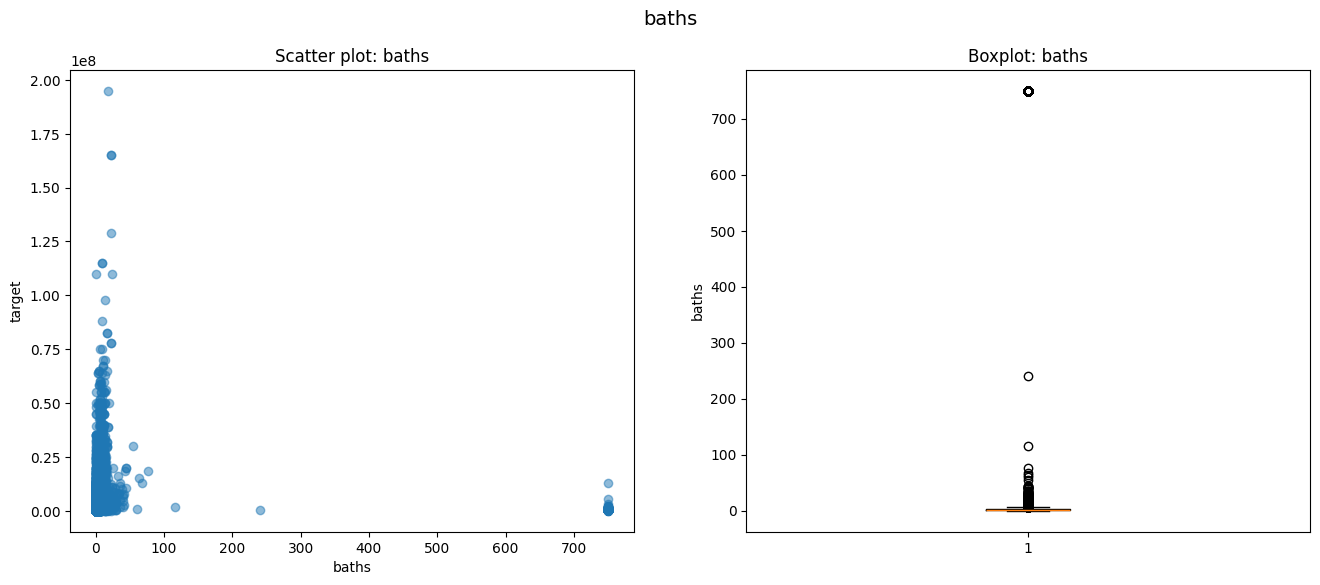

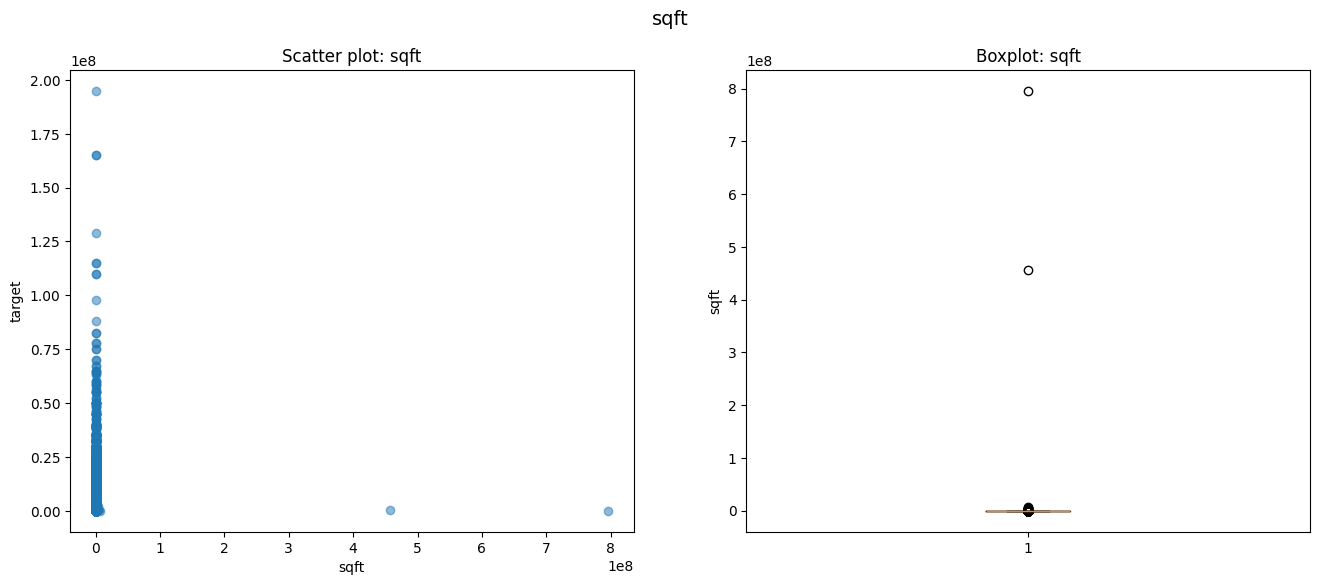

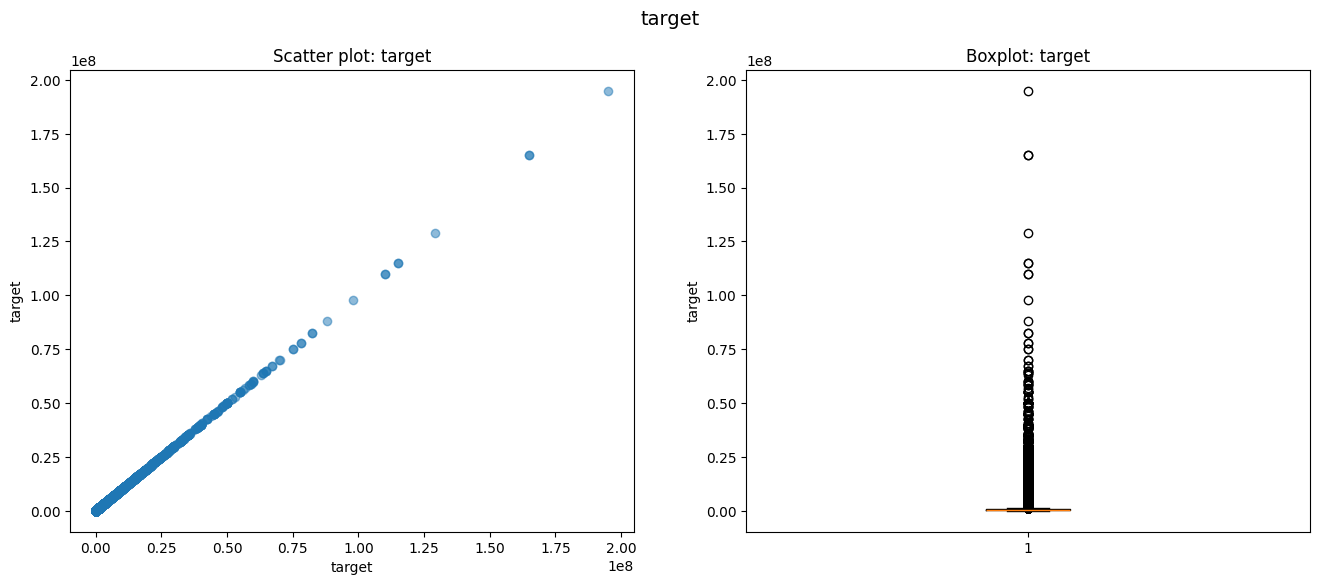

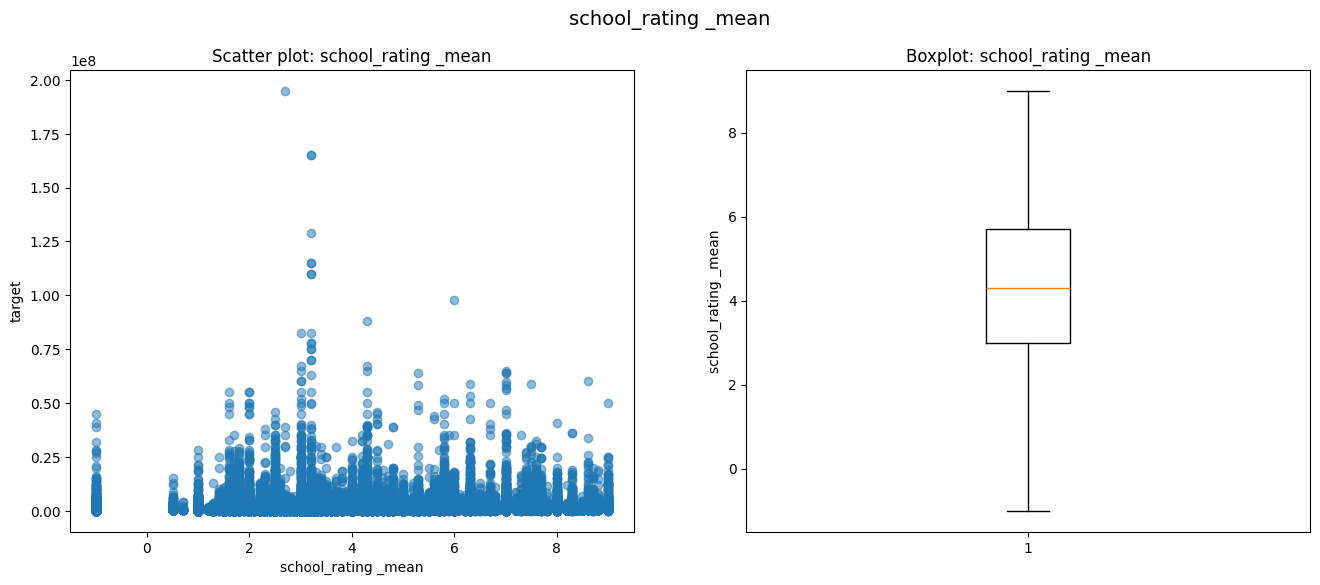

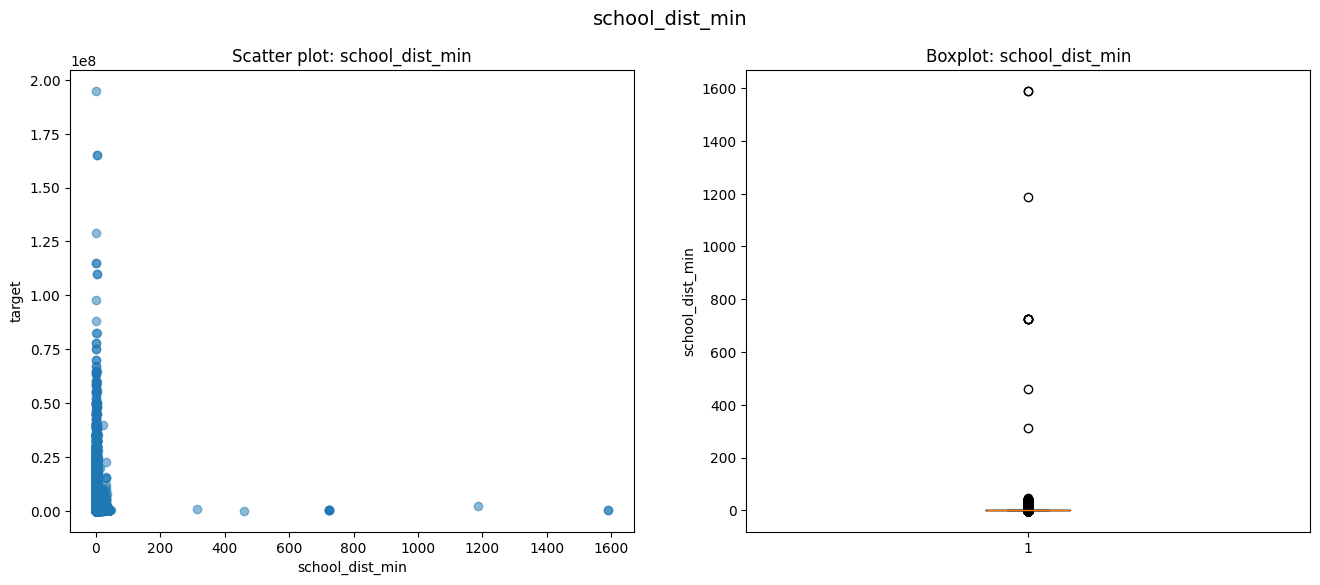

In [112]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

* По ванным комнатам - нужно посмотреть 116, 241 и 750 ванных комнат, слишком низкая цена при таком колличестве 
* По площади - нужно посмотреть значения 0 и цена 195 милионов, а так же площади больше 456
* По школам - растояния больше 200

In [113]:
# выведем интересующие нас строки
condition = (df['baths'].isin([116,241,750]))
filtered_df = df[condition]
# Вывести отфильтрованные строки
display(filtered_df.head(5))
# Подсчет среднего значения 'sqft'
average_sqft = filtered_df['sqft'].mean()
# Вывести среднее значение 'sqft'
print("Среднее значение sqft: ", average_sqft)

,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
981,Active,3624 Douglas Ave,750.0,Dallas,1758,75219,TX,499000,False,other,1993,False,True,False,True,2.6,0.9
1788,Active,920 I St NW #411,750.0,Washington,1367,20001,DC,1499000,False,other,2013,False,False,False,False,6.8,0.3
3157,Active,601 W 11th Ave #409,750.0,Denver,873,80204,CO,348900,False,other,1981,True,True,False,False,4.0,0.2
6664,Active,1260 Xavier St,750.0,Denver,1864,80204,CO,560000,False,other,1936,True,False,False,False,2.0,0.5
6784,Active,3314 Douglas Ave Unit 202D,750.0,Dallas,1336,75219,TX,285000,False,condo,1984,False,True,False,True,2.0,1.0


Среднее значение sqft:  2101.8870292887027


Используем поиск, проверим 15 адресов с значением 750 ванных - все это квартиры имеющие в среднем 2 ванные комнаты, поэтому удалим эти выбросы

In [ ]:
# Удаляем выбросы, соответствующие условию
df.drop(df[condition].index, inplace=True)

In [115]:
condition1 = ((df['sqft'] == 0) & (df['target'] == 195000000)) | (df['sqft'] > 455000000)
filtered1_df = df[condition1]
# Вывести отфильтрованные строки
display(filtered1_df)

,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
55327,For Sale,1723 Pulte St,2.0,Cincinnati,795979430,45225,OH,27500,False,single_family_home,1901,True,True,True,True,2.5,0.78
116537,For Sale,875 Nimes Rd,18.0,Los Angeles,0,90077,CA,195000000,True,single_family_home,1935,True,True,True,True,2.7,1.30
331276,Active,5382 S Dixie Hwy,0.0,Glendale,456602479,42740,KY,198000,False,multi_family_home,2012,True,True,False,False,6.3,3.10


Удалим и эти строки


In [ ]:
# Удаляем выбросы, соответствующие условию
df.drop(df[condition1].index, inplace=True)

In [117]:
condition2 = (df['school_dist_min']> 200)
filtered2_df = df[condition2]
# Вывести отфильтрованные строки
print(len(filtered2_df))
display(filtered2_df.head(5))

10


,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
23354,Other,73 Park Rd,4.0,Falcon Heights,6000,78545,TX,670000,False,single_family_home,1980,True,True,True,False,2.5,312.40
96926,For Sale,108 N Nbelvedere Blvd #29,0.0,Santa Ana,890,92703,TN,48640,False,single_family_home,1963,True,True,False,True,2.7,1590.36
149215,For Sale,253 W Wnorwood Ave,0.0,Spring,720,77380,TN,18000,False,single_family_home,1950,True,False,False,True,7.5,460.86
179635,For Sale,5600 Pine Tree Dr,6.0,Miami Beach,4173,33140,FL,2350000,True,single_family_home,1949,True,False,True,False,5.5,1187.14
190201,For Sale,2318 E Ewarren St,3.0,Needmore,1230,17238,TN,57225,False,single_family_home,1953,True,True,False,True,5.5,725.17


In [118]:
# Удаляем выбросы, соответствующие условию
df.drop(df[condition2].index, inplace=True)

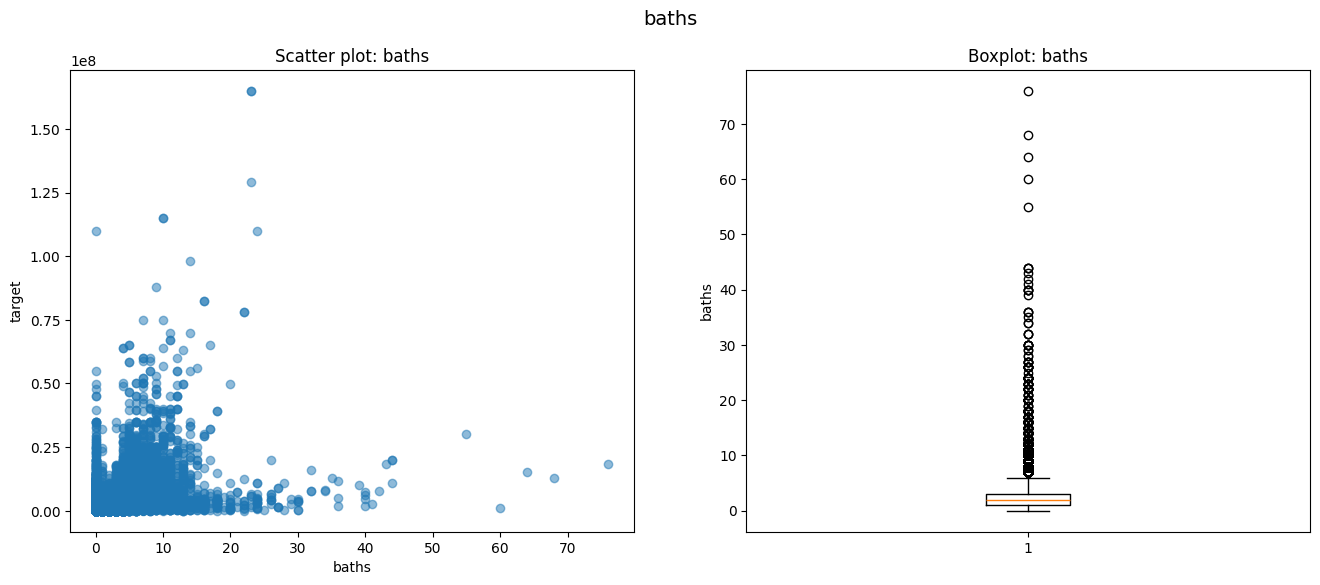

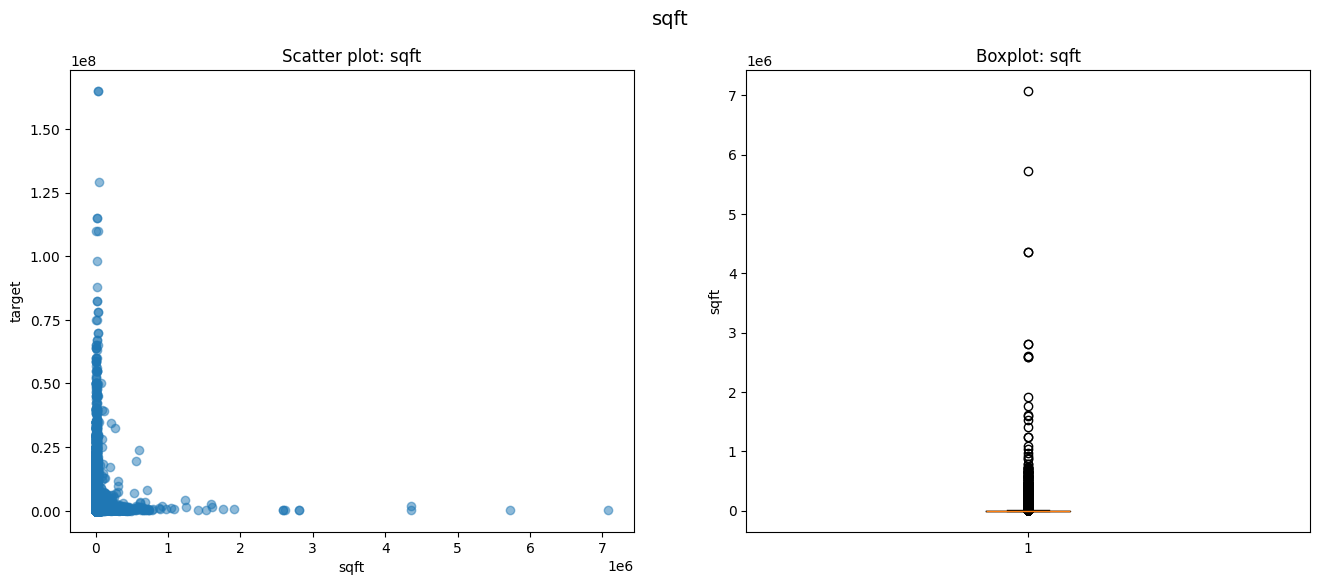

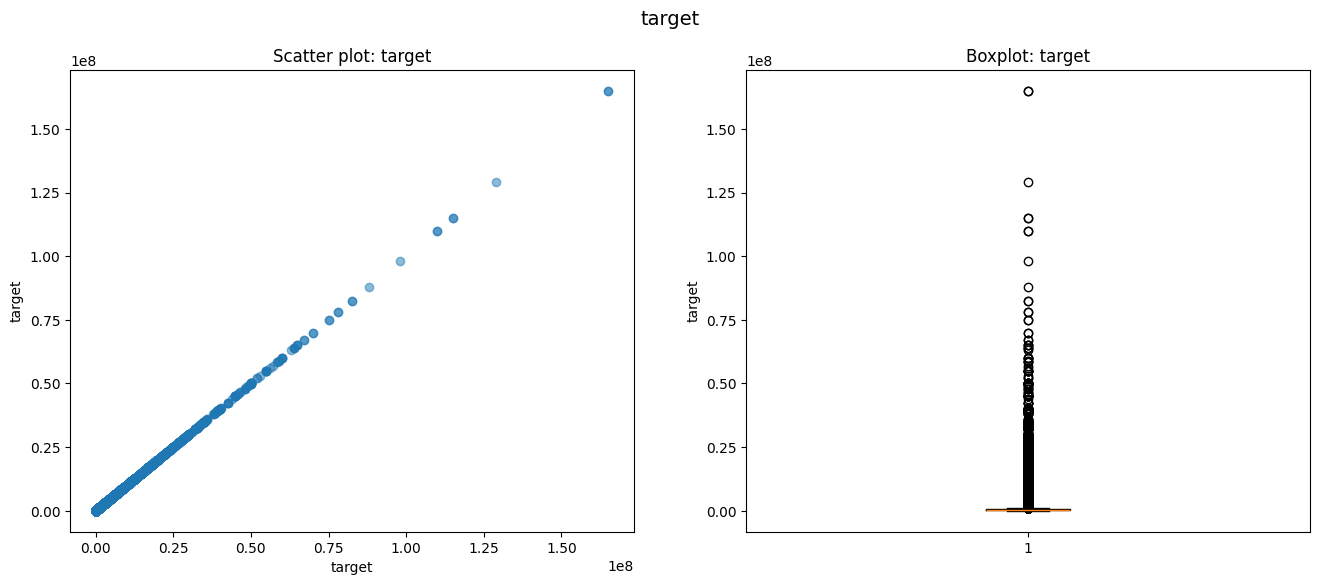

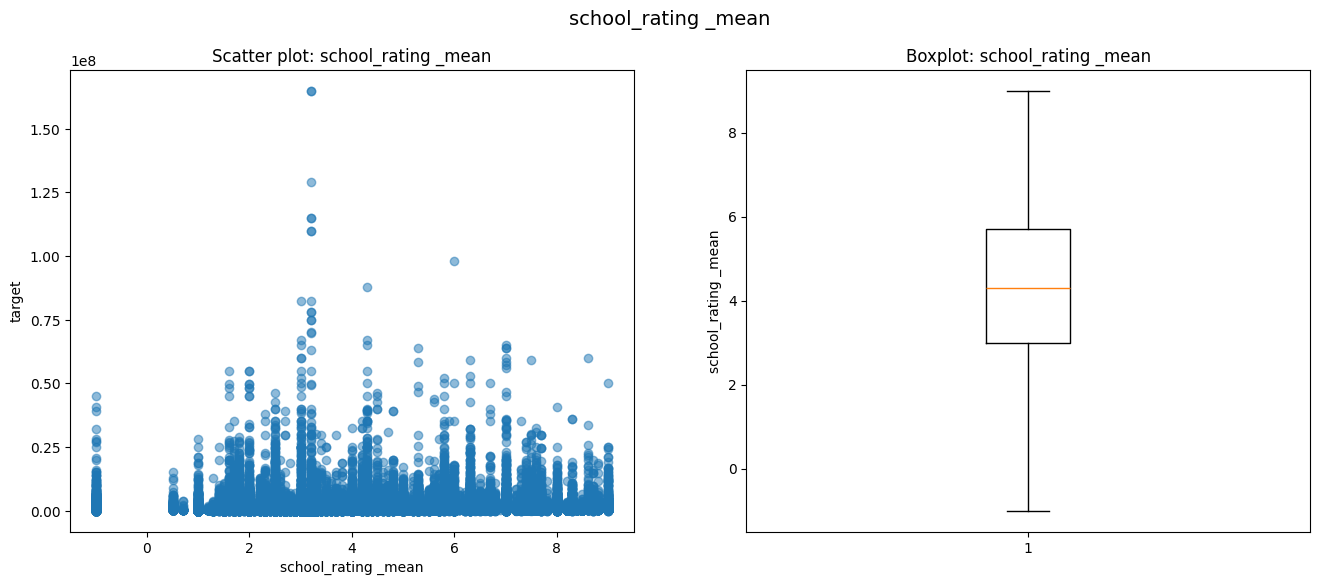

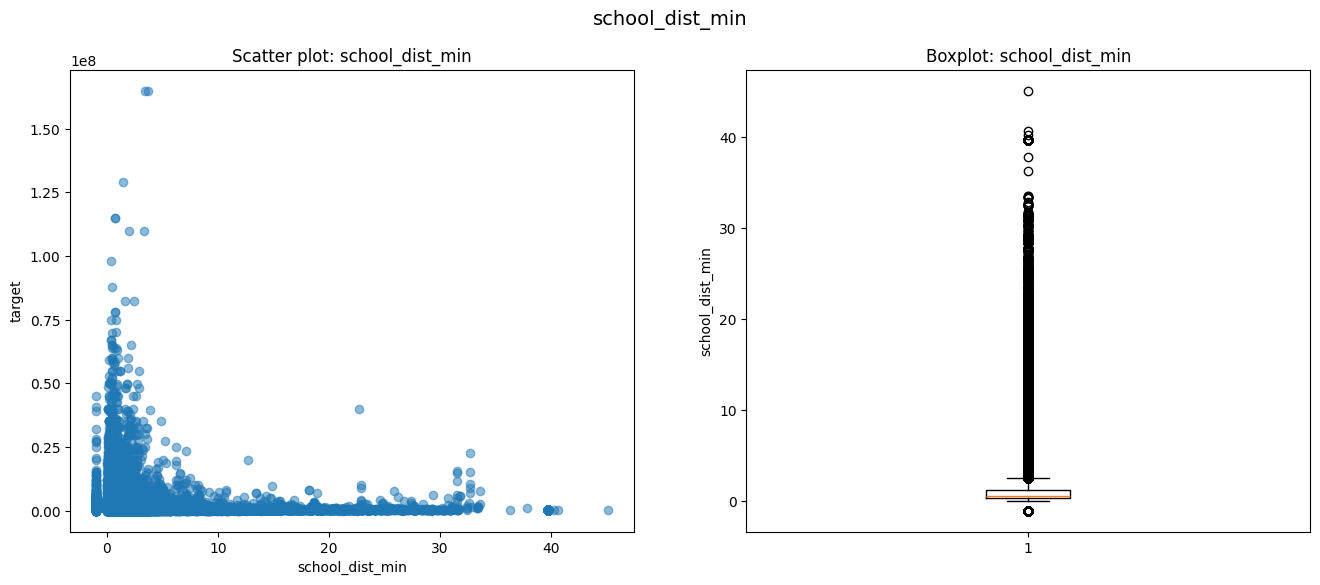

In [119]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

Непонятные значения остались, поэтому выведем и посчитаем сколько у нас таких значений

In [120]:
condition3 = ((df['baths'] > 30) | (df['target'] > 750000)) | (df['sqft'] > 200000) |(df['school_dist_min']> 35)
filtered3_df = df[condition3]
# Вывести отфильтрованные строки
print(len(filtered3_df))
display(filtered3_df.head(5))

59199


,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
2,For Sale,2005 Westridge Rd,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,4311 Livingston Ave,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
14,For Sale,930 52nd St,0.0,Brooklyn,0,11219,NY,1650000,False,single_family_home,1905,False,True,False,False,6.3,0.20
16,Active,24 W 126th St,0.0,New York,3325,10027,NY,2650000,False,townhouse,1899,False,False,False,False,2.5,0.10
20,For Sale,61425 Gosney Rd,5.0,Bend,5266,97702,OR,3500000,False,single_family_home,2008,True,True,True,True,6.3,3.70


In [121]:
# Удаляем выбросы, соответствующие условию
df.drop(df[condition3].index, inplace=True)

In [122]:
condition4 = ((df['baths'] < 1) | (df['sqft'] < 1))
filtered4_df = df[condition4]
# Вывести отфильтрованные строки
print(len(filtered4_df))
display(filtered4_df.head(5))

61724


,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
4,For Sale,1624 S Newkirk St,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00
5,Active,552 Casanova Ct,0.0,Poinciana,1507,34759,FL,181500,False,other,2006,True,True,False,False,2.3,0.80
6,Active,6094 Mingle Dr,0.0,Memphis,0,38115,TN,68000,False,other,1976,False,False,False,False,2.7,0.40
10,Active,4222 False Cypress Ln,0.0,Houston,3130,77068,TX,260000,False,other,2015,True,True,False,False,4.2,0.40
34,For Sale,423 N Church St #13-A,0.0,Charlotte,900,28202,NC,260000,False,condo,1981,False,False,False,False,6.3,0.48


In [123]:
# Удаляем выбросы, соответствующие условию
df.drop(df[condition4].index, inplace=True)

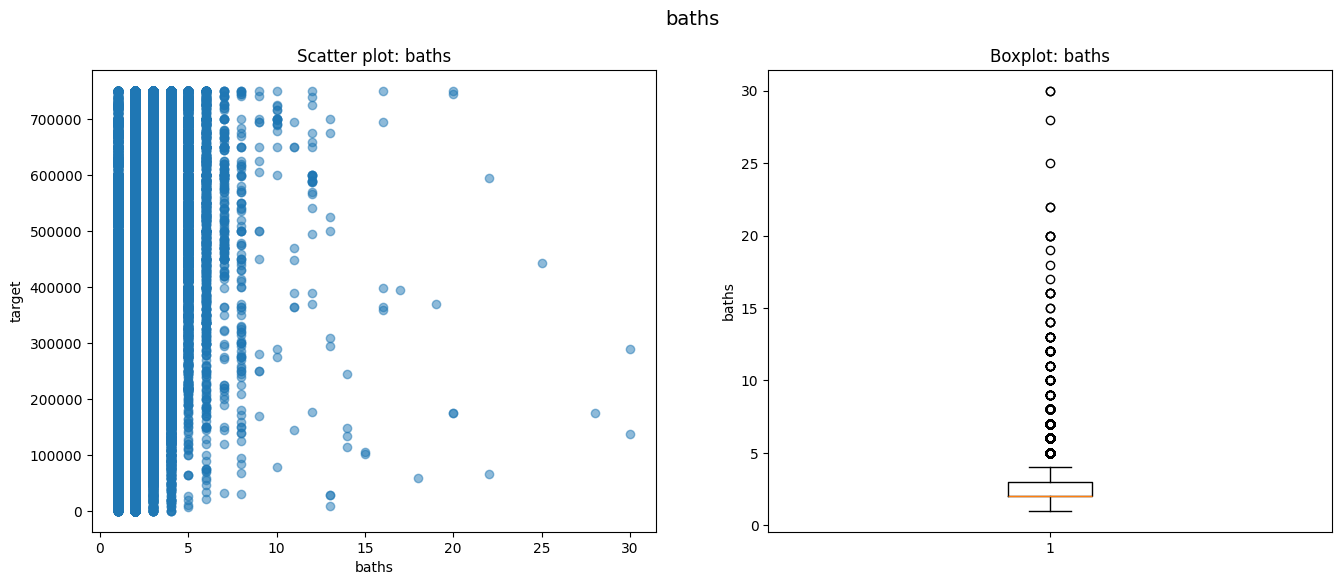

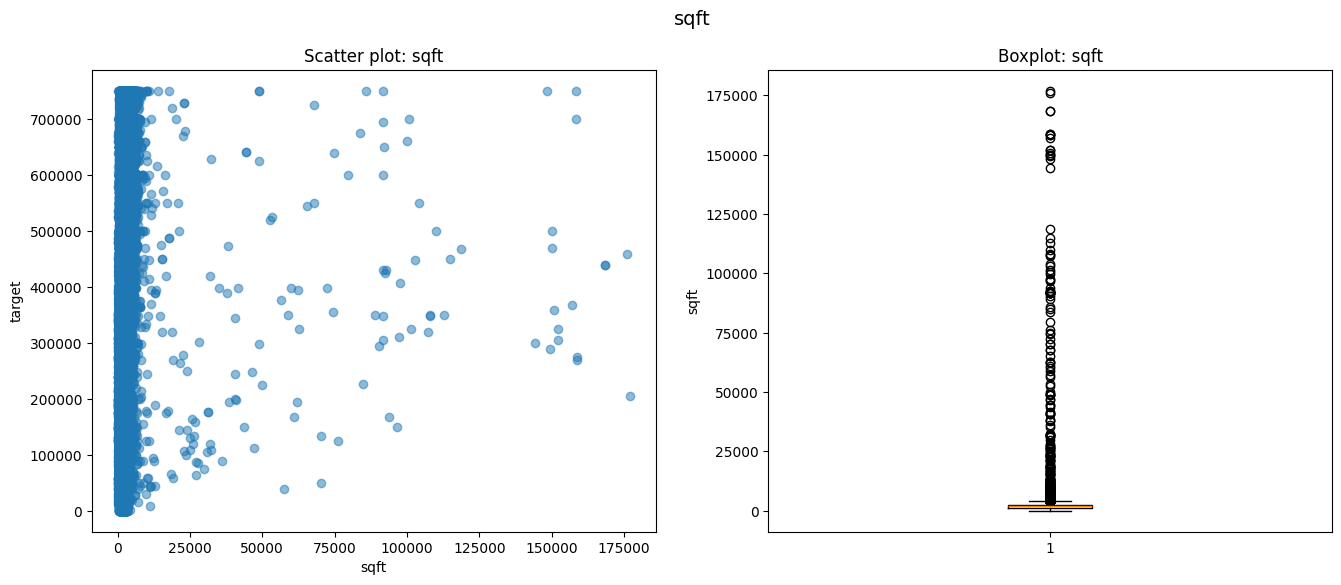

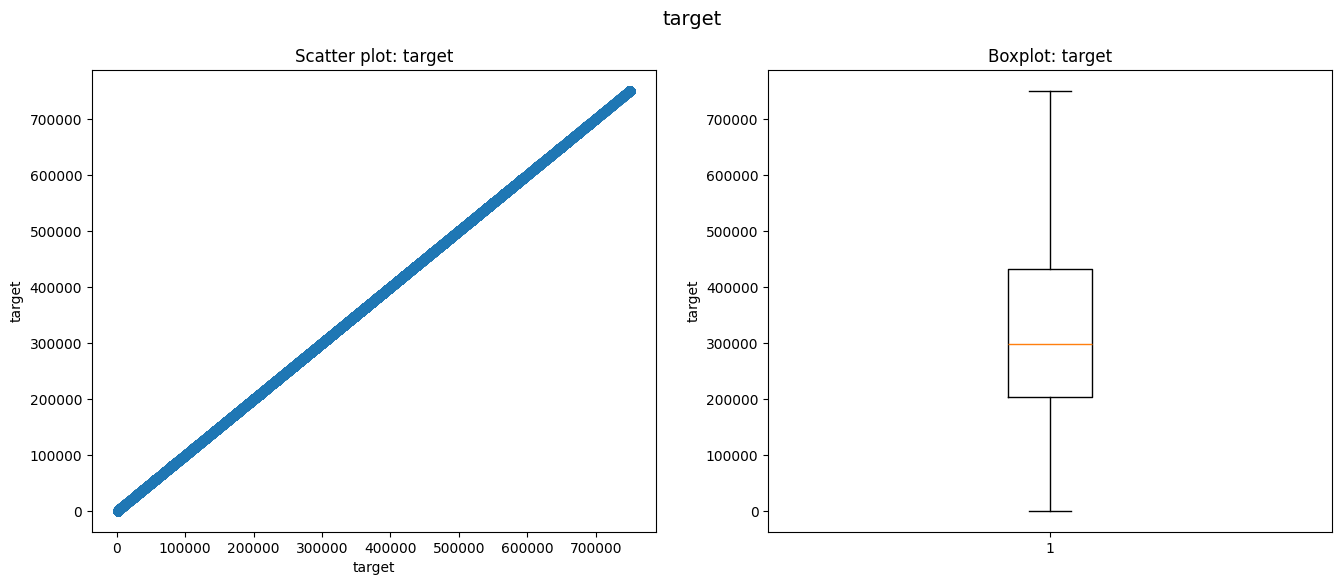

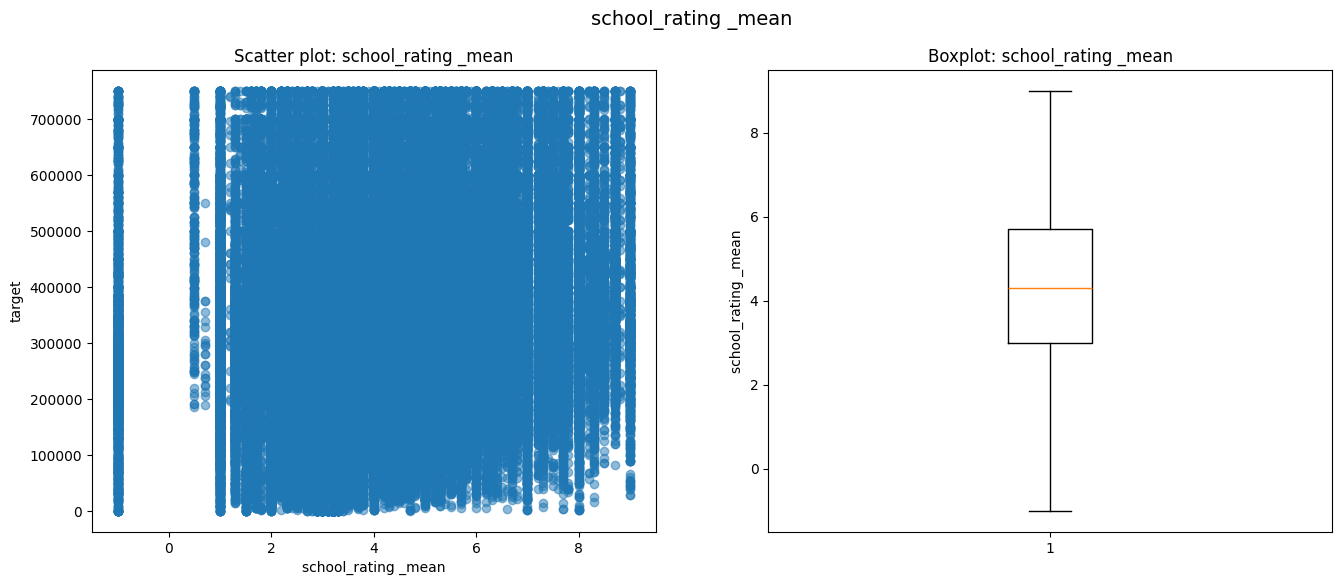

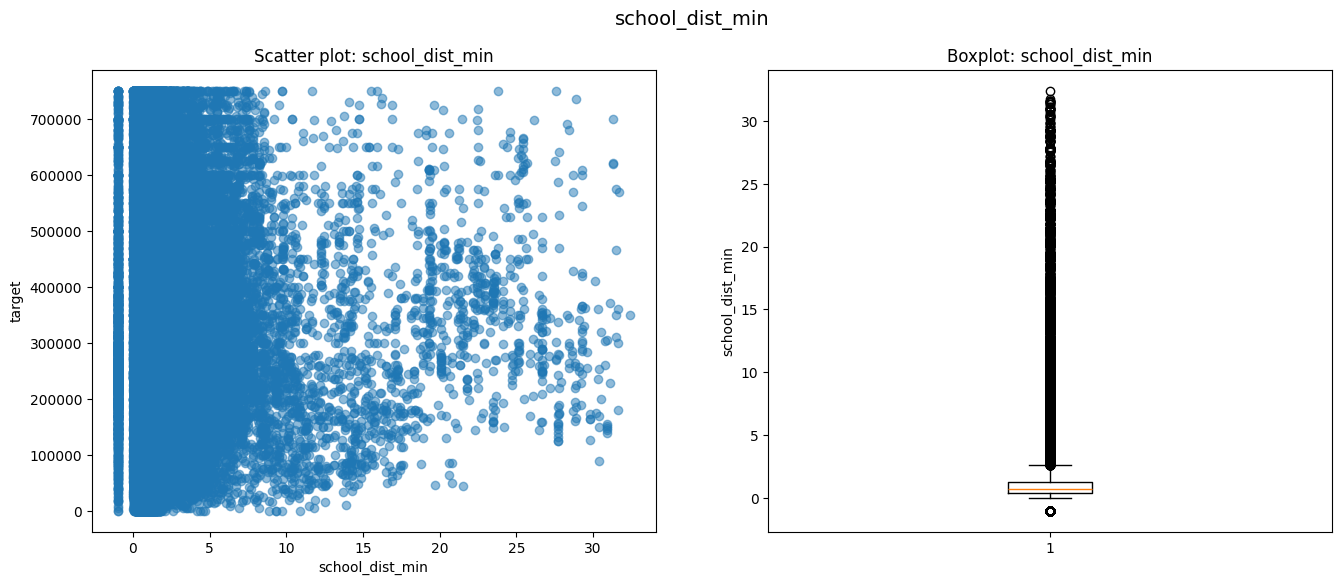

In [124]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

In [125]:
# удалим признак street
df = df.drop(columns=['street'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210669 entries, 0 to 331843
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               210669 non-null  object 
 1   baths                210669 non-null  float64
 2   city                 210669 non-null  object 
 3   sqft                 210669 non-null  int64  
 4   zipcode              210669 non-null  object 
 5   state                210669 non-null  object 
 6   target               210669 non-null  int64  
 7   pool_encoded         210669 non-null  bool   
 8   Type                 210669 non-null  object 
 9   Year built           210669 non-null  object 
 10  Heating_encoded      210669 non-null  bool   
 11  Cooling_encoded      210669 non-null  bool   
 12  Parking_encoded      210669 non-null  bool   
 13  fireplace_encoded    210669 non-null  bool   
 14  school_rating _mean  210669 non-null  float64
 15  school_dist_min      2

Посморим на распределение признаков

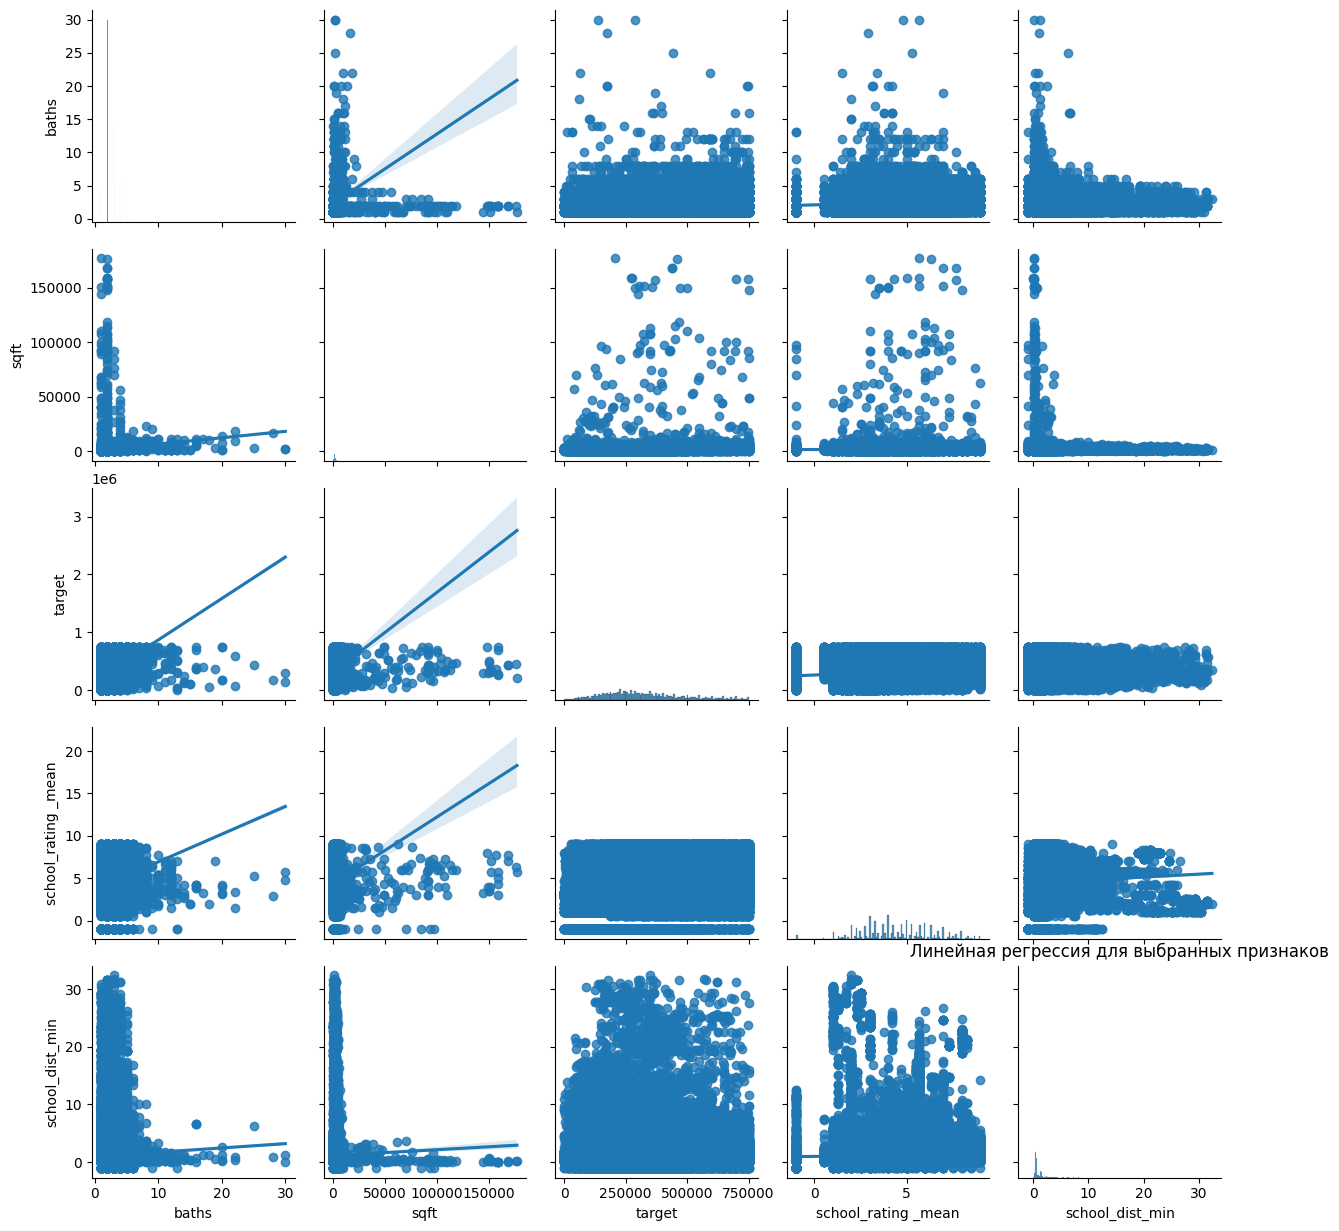

In [ ]:
# Отбираем только нужные признаки из датасета
data_selected = df[num_features]
# Строим линейную регрессию для выбранных признаков
sns.pairplot(data_selected, kind='reg')
#Добавляем заголовок
plt.title('Линейная регрессия для выбранных признаков')
# Сохраняем график в файл с расширением PNG
plt.savefig('image/plot.png', format='png')
# Отображаем график
plt.show()

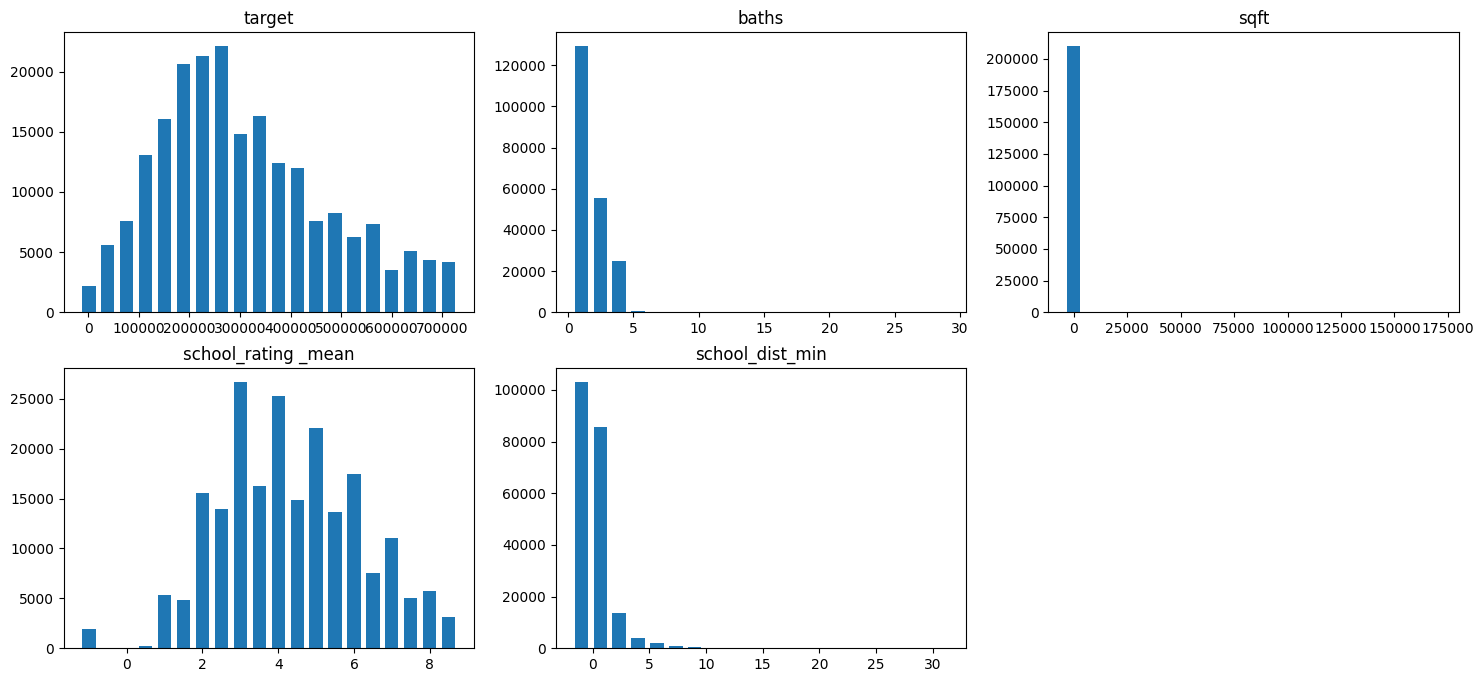

In [128]:
visualize_distributions({
    'target': df['target'],
    'baths': df['baths'],
    'sqft': df['sqft'],
    'school_rating _mean': df['school_rating _mean'],
    'school_dist_min': df['school_dist_min'],
})

Видим, что числовые признаки необходимо нормализовть и логорифмировать для получения нормального распределения.

Ранг матрицы корреляций: 5
Определитель матрицы корреляций: 0.7559163


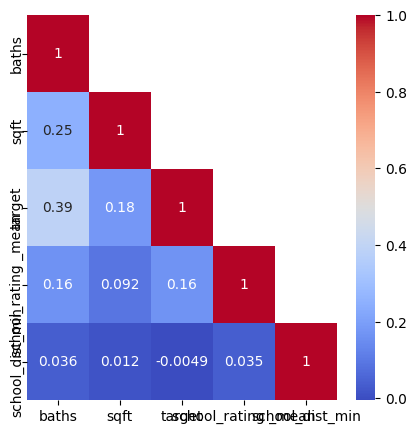

In [129]:
# Проверяем на мультиколлинеарность и корреляцию числовых признаков между собой и с главным признаком "target":
# строим матрицу корреляций
corr_matrix = np.corrcoef(df[num_features], rowvar=False)
print('Ранг матрицы корреляций:', np.linalg.matrix_rank(corr_matrix))
print('Определитель матрицы корреляций: {:.7f}'.format(np.linalg.det(corr_matrix)))

# формируем нижний треугольник матрицы корреляций
corr_matrix_tril = np.tril(corr_matrix)
# заполняем верхний треугольник значениями NaN
corr_matrix_tril[corr_matrix_tril == 0] = np.nan

# создаем фигуру с автоматическим масштабированием
plt.figure(figsize=(len(df[num_features].columns), len(df[num_features].columns)))

# строим тепловую карту
sns.heatmap(corr_matrix_tril, annot=True, cmap='coolwarm', mask=np.isnan(corr_matrix_tril))
# добавляем подписи столбцов на тепловой карте
plt.xticks(np.arange(len(df[num_features].columns))+0.5, df[num_features].columns, rotation=0, ha='center', fontsize=10)
plt.yticks(np.arange(len(df[num_features].columns))+0.5, df[num_features].columns, ha='center', fontsize=10, va='center', rotation=90)
# отображаем график
plt.show()

Мультиколлинеарность отсутствует

## Анализ номинативных переменных

Посмотрим на распределение стоимости квартир в зависимости от значения номинативных переменных.

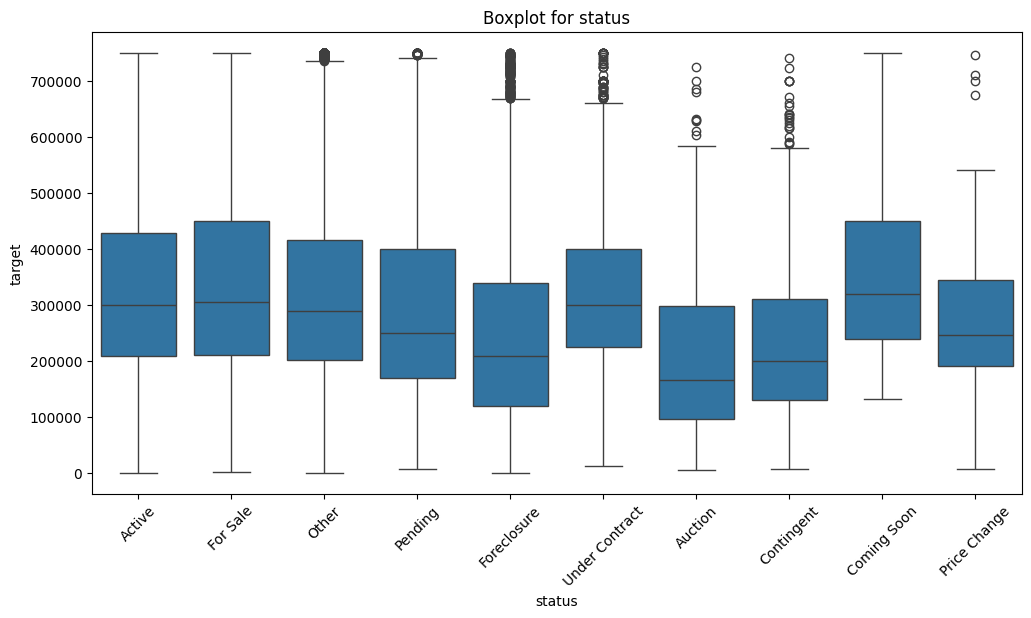

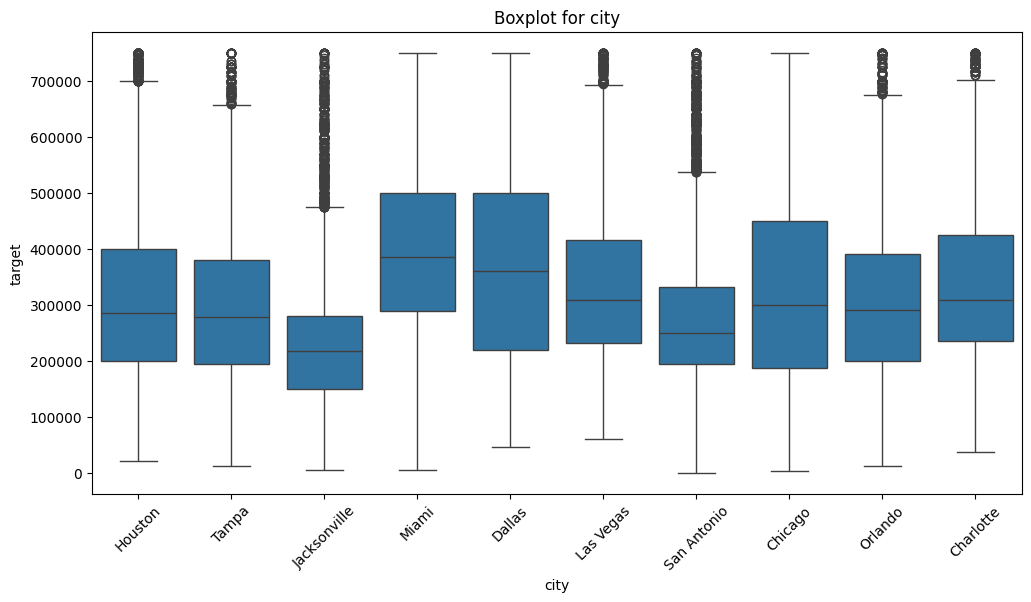

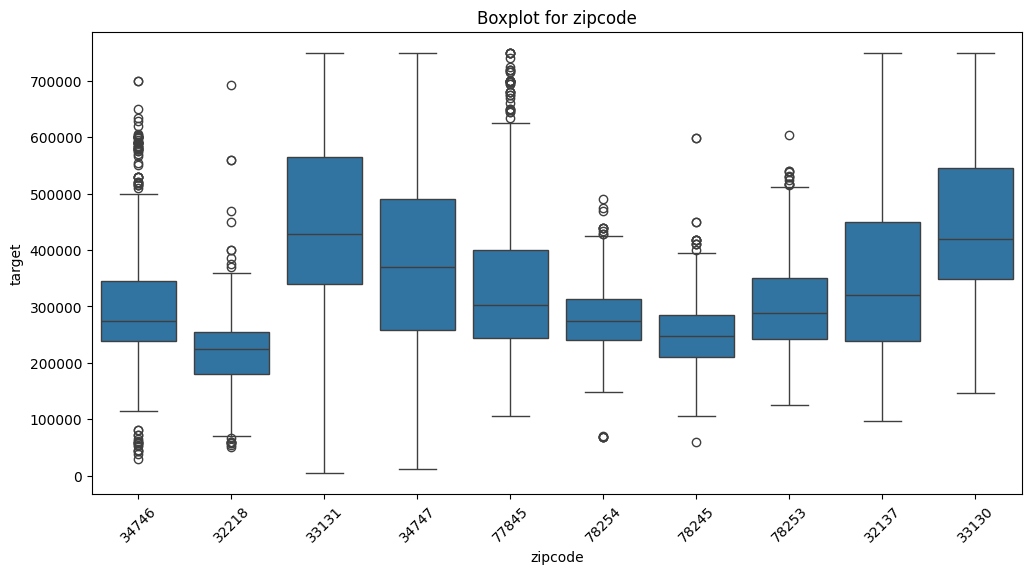

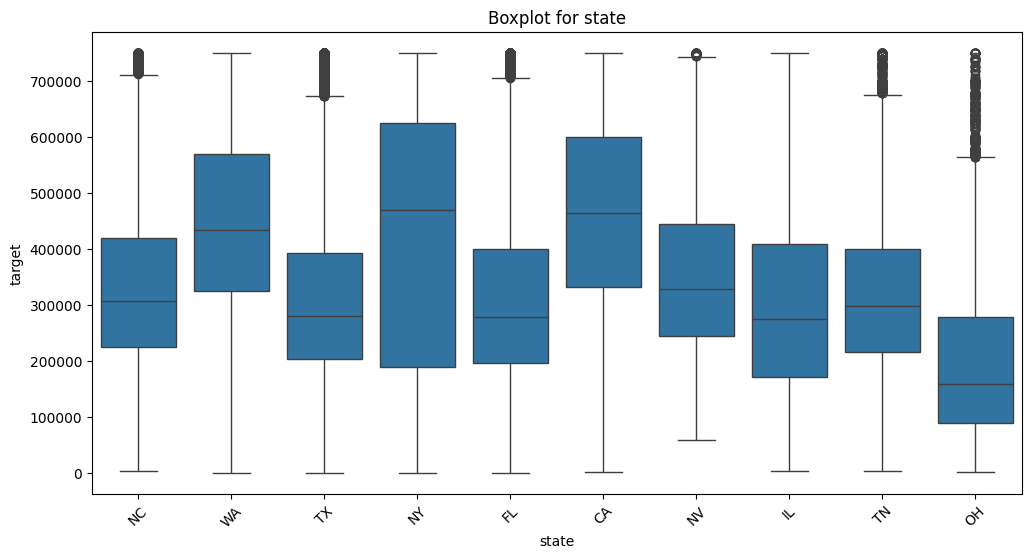

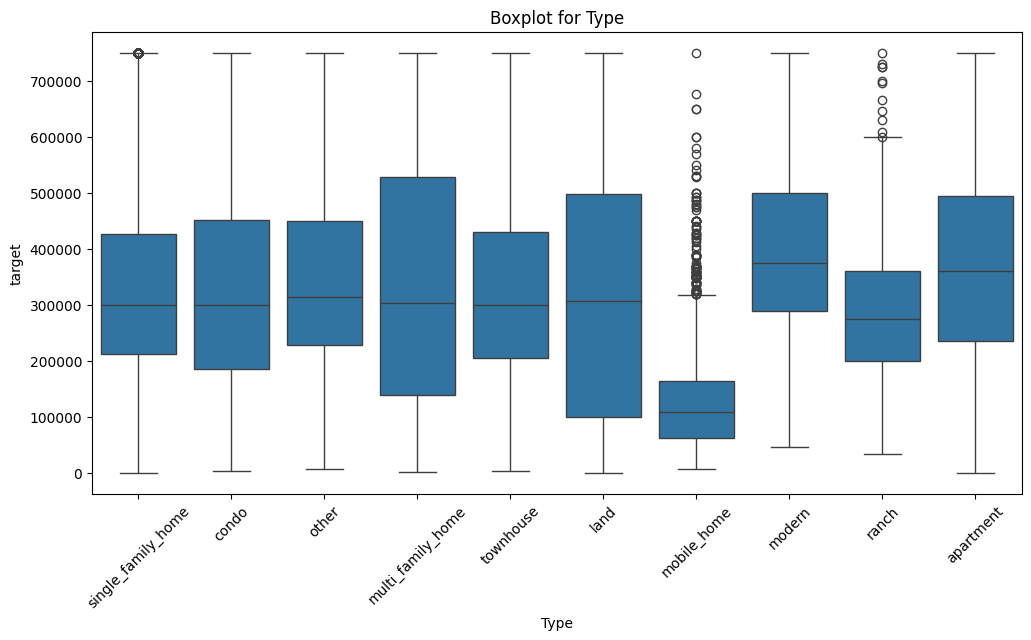

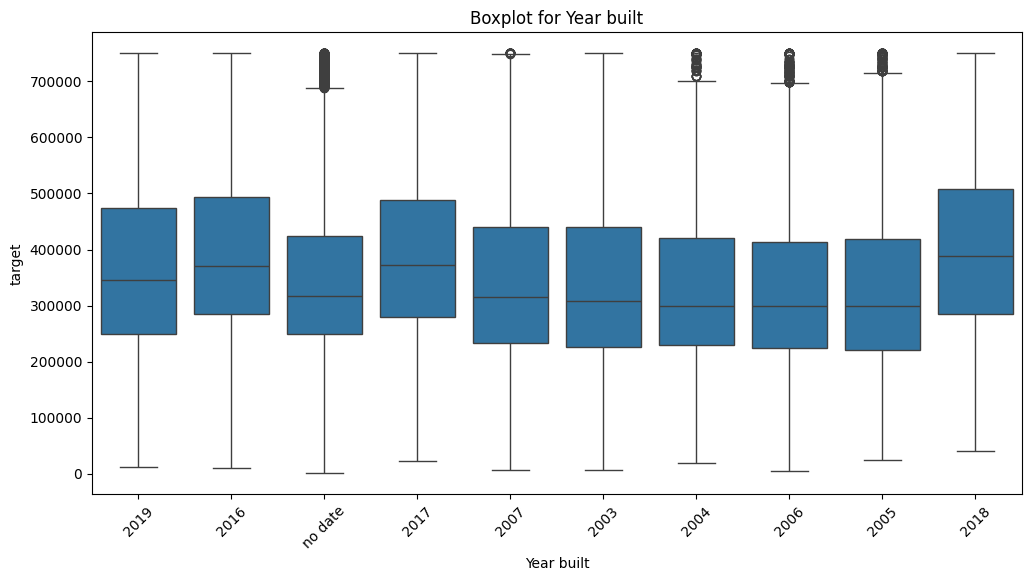

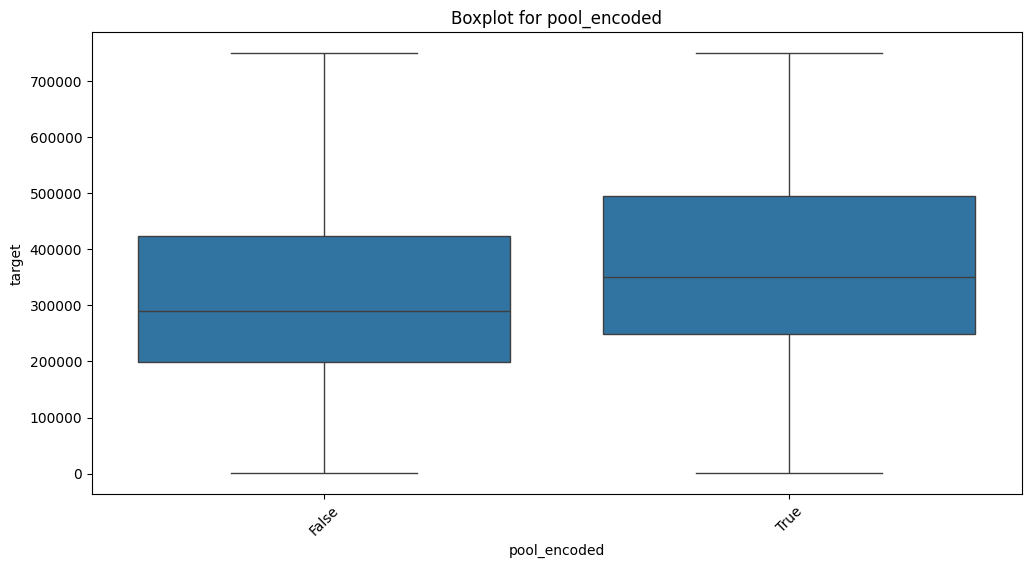

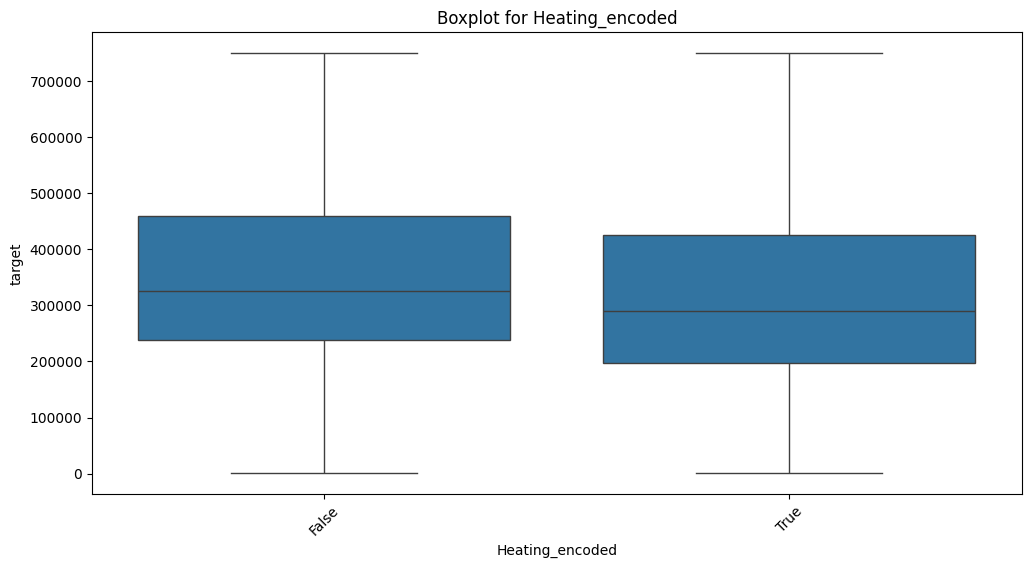

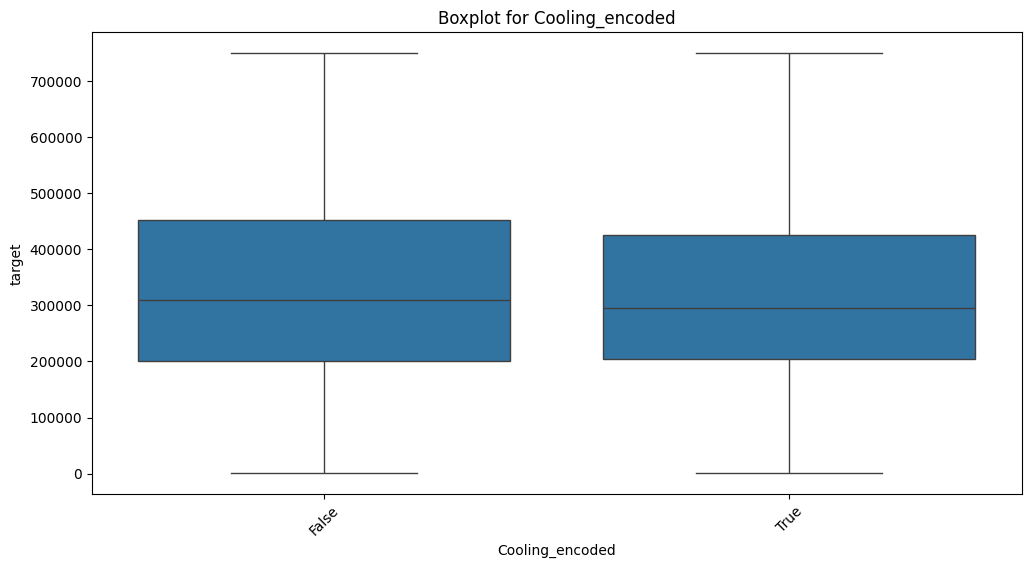

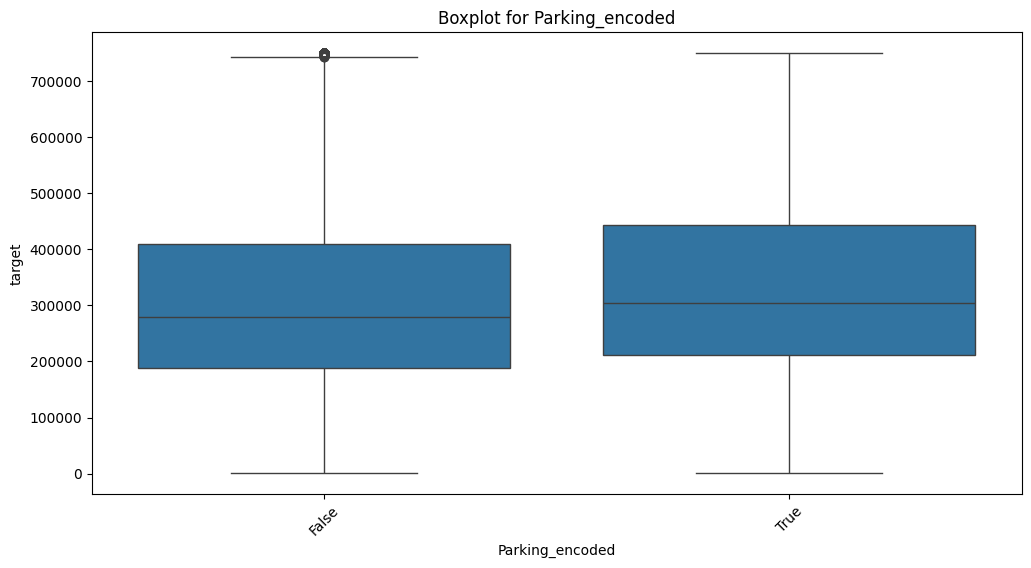

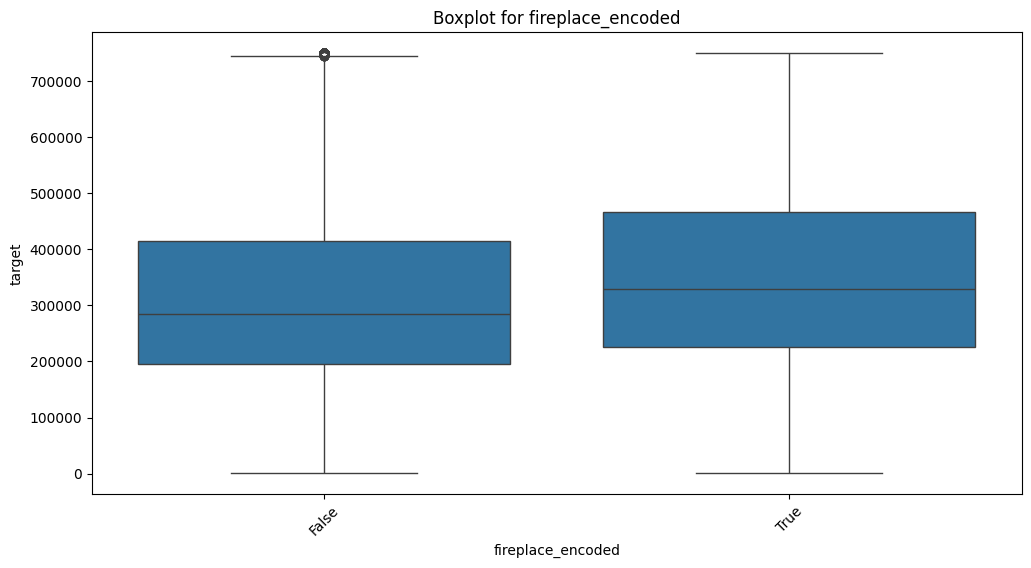

In [130]:
for col in chain(cat_features, bin_features):
    get_boxplot(col)

Из графиков можно понять, что все параметры могут влиять на стоимость.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения стоимости недвижимости по различным параметрам неразличимы.

In [172]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combination = itertools.combinations(cols, 2)
    combinations_all = list(combination)
    for comb in combinations_all:
        if stats.ttest_ind(df.loc[df.loc[:, column] == comb[0], 'target'], 
                        df.loc[df.loc[:, column] == comb[1], 'target']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [173]:
for col in chain(cat_features, bin_features):
    get_stat_dif(col)

Найдены статистически значимые различия для колонки status
Найдены статистически значимые различия для колонки city
Найдены статистически значимые различия для колонки zipcode
Найдены статистически значимые различия для колонки state
Найдены статистически значимые различия для колонки Type
Найдены статистически значимые различия для колонки Year built
Найдены статистически значимые различия для колонки pool_encoded
Найдены статистически значимые различия для колонки Heating_encoded
Найдены статистически значимые различия для колонки Cooling_encoded
Найдены статистически значимые различия для колонки Parking_encoded
Найдены статистически значимые различия для колонки fireplace_encoded


>**ИТОГ:** все признаки являются значимыми

# Результаты EDA

В результате EDA мы проделали следующую работу:
* Избавились от пропусков влияющих на целевую переменную.
* Избавились от выбросов.
* Провели корреляционный анализ числовых признаков.
* Посмотрели на распределение числовых признаков, в результате решили в дальнейшем нормализовать и логорифмировать числовые признаки.
* Провели анализ номинативных переменных.

Сохраним датасет для дальнейшего использования при обучении модели.

In [174]:
df.to_csv('data/data_model.csv', index=False)